#### Setup

In [42]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
import scipy.stats as st

# set plotting theme
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": "large",
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/"
dpi = 600

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
N = 100
D = 2
train_x = torch.empty((N,D))
train_y = torch.empty((N,))

# create fixed hyperparameters

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(5),
        'covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(1.),
        'covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(92.),
        'covar_module.base_kernel.kernels.0.period_length': torch.tensor(.35),
        'mean_module.constant': torch.tensor(5.2)
    }, 
    # {
    #     'likelihood.noise_covar.noise': torch.tensor(1),
    #     'covar_module.outputscale': torch.tensor(8.),
    #     'covar_module.base_kernel.lengthscale': torch.tensor([9., .85]),
    #     'mean_module.constant': torch.tensor(5.2)
    # }
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(8.),
        'covar_module.base_kernel.lengthscale': torch.tensor([1., .75]),
        'mean_module.constant': torch.tensor(7)
    }, 
]

# initialise the m1
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = ScaleKernel(AdditiveKernel(
    PeriodicKernel(active_dims=[0]),
    RBFKernel(active_dims=[1])))
m1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood1, kernel=kernel1)
m1.initialize(**hypers[0])

# initialise the m2
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
kernel2 = ScaleKernel(RBFKernel(ard_num_dims=train_x.shape[-1]))
m2 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood2, kernel=kernel2)
m2.initialize(**hypers[1])

x1 = torch.linspace(0, 1, N)
x2 = torch.linspace(0, 1, N)

x1_grid, x2_grid = torch.meshgrid([x1, x2])
X_grid = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))

Y_surface0 = torch.empty((N**2,2))

m1.eval()
torch.manual_seed(55)
with gpytorch.settings.prior_mode(True):
    Y_surface0[:,0] = m1(X_grid).sample()

m2.eval()
torch.manual_seed(57)
with gpytorch.settings.prior_mode(True):
    Y_surface0[:,1] = m2(X_grid).sample()

<Axes: >

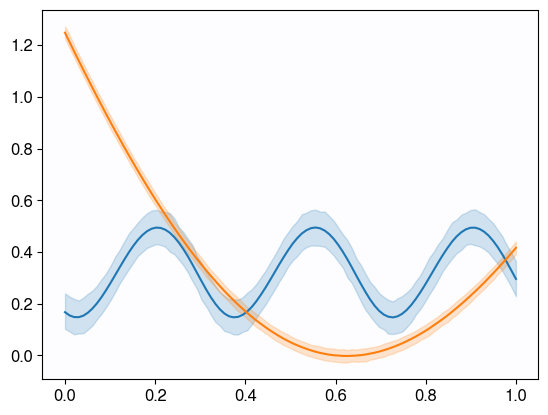

In [4]:
sns.lineplot(x=X_grid[:,0], y=Y_surface0[:,0])
sns.lineplot(x=X_grid[:,1], y=Y_surface0[:,0])

<Axes: >

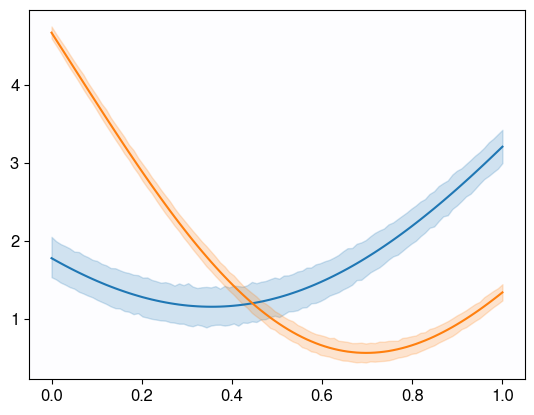

In [5]:
sns.lineplot(x=X_grid[:,0], y=Y_surface0[:,1])
sns.lineplot(x=X_grid[:,1], y=Y_surface0[:,1])

#### GP

##### Compare with noiseless GP, fixed noise GP, heteroscedastic GP

In [6]:
# params
n_samples = 500
torch.manual_seed(88)
idx = torch.randint(0,10000,(n_samples,))
view_init = (-330, 45)

x1 = x1_grid.flatten().numpy()[idx]
x2 = x2_grid.flatten().numpy()[idx]

# increase signal
signal_var = 10
Y_surface = Y_surface0.clone()
Y_surface[...,0] = signal_var*Y_surface[...,0]

# samples
samples1 = Y_surface[idx,0].numpy()
sampling_dist2 = dist.Normal(Y_surface[idx,0], torch.tensor(3.))
samples2 = sampling_dist2.sample_n(1).squeeze(0).numpy()
sd = torch.exp(.15*Y_surface[idx,0])
sampling_dist3 = dist.Normal(Y_surface[idx,0], sd)
samples3 = sampling_dist3.sample_n(1).squeeze(0).numpy()

# Select a subset of points for which to draw the lines
num_lines = 100
np.random.seed(20)
line_indices = np.random.choice(len(x1), num_lines, replace=False)

# Get the z values from the surface at the scatter points
z_surface = Y_surface[idx,0].numpy()

# Calculate whether each scatter point is above or below the surface
above_surface1 = samples1 > z_surface
above_surface2 = samples2 > z_surface
above_surface3 = samples3 > z_surface

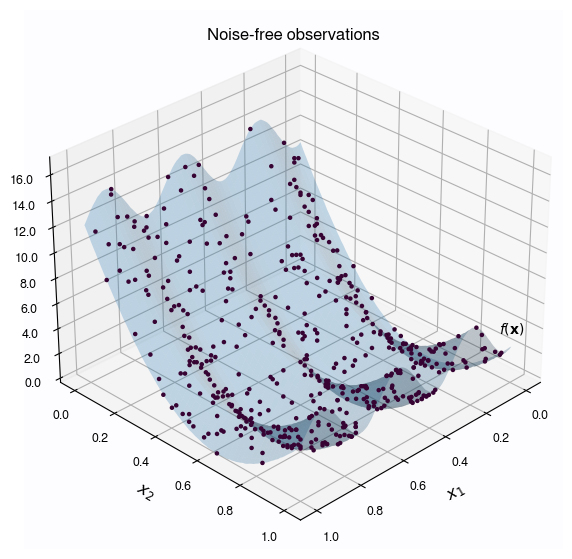

In [7]:
# Plot 1

# Create figure
fig = plt.figure(figsize=(7,7))
fs = 9
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=.25)
ax1.scatter(x1[above_surface1], x2[above_surface1], samples1[above_surface1], color='#c989c4', alpha=1, s=5)
ax1.scatter(x1[~above_surface1], x2[~above_surface1], samples1[~above_surface1], color='#360332', alpha=1, s=5)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
# ax1.set_zlabel("f(x)", labelpad=-2.5, fontsize=12)
ax1.set_zlim(0, 17)
ax1.set_xticklabels(ax1.get_xticks().round(1), fontsize=fs)
ax1.set_yticklabels(ax1.get_yticks().round(1), fontsize=fs)
ax1.set_zticklabels(ax1.get_zticks().round(1), fontsize=fs)
ax1.annotate("$f(\mathbf{x})$", (.068,-.021), fontsize=10)
ax1.view_init(*view_init)
# ax1.grid(False)
# ax1.set_xticks([0, 1])
# ax1.set_yticks([0, 1])
# ax1.set_zticks([])
ax1.set_title('Noise-free observations', y=1.01)

# fig.subplots_adjust(left=0.5, right=1000000, bottom=0.05, top=0.95)

fig.tight_layout()
# fig.set_tight_layout(True)

# fig.savefig(os.path.join(save_image_path, "Gaussian_likelihood_1.png"), dpi=dpi, pad_inches=0)

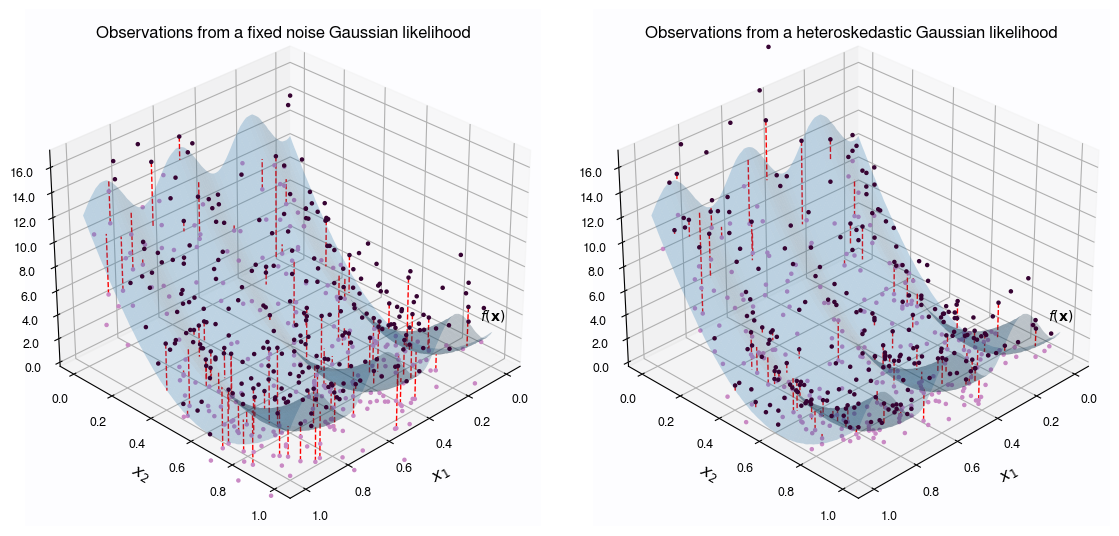

In [8]:
# Plot 2

# Create figure
fig = plt.figure(figsize=(14,7))

# Plot 2
ax2 = fig.add_subplot(121, projection='3d')
ax2.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=.25)
ax2.scatter(x1[above_surface2], x2[above_surface2], samples2[above_surface2], color='#360332', alpha=1, s=5) 
ax2.scatter(x1[~above_surface2], x2[~above_surface2], samples2[~above_surface2], color='#c989c4', alpha=1, s=5)

for i in line_indices:
    ax2.plot([x1[i], x1[i]], [x2[i], x2[i]], [samples2[i], z_surface[i]], color='red', lw=1, ls="--")

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# ax2.set_zlabel("f(x)", labelpad=-2.5)
ax2.set_zlim(0, 17)
ax2.set_xticklabels(ax2.get_xticks().round(1), fontsize=fs)
ax2.set_yticklabels(ax2.get_yticks().round(1), fontsize=fs)
ax2.set_zticklabels(ax2.get_zticks().round(1), fontsize=fs)
ax2.annotate("$f(\mathbf{x})$", (.068,-.021), fontsize=10)
ax2.view_init(*view_init)
# ax2.grid(False)
# ax2.set_xticks([0, 1])
# ax2.set_yticks([0, 1])
# ax2.set_zticks([])
ax2.set_title('Observations from a fixed noise Gaussian likelihood', y=1.01)


# Plot 3
ax3 = fig.add_subplot(122, projection='3d')
ax3.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=.25)
ax3.scatter(x1[above_surface3], x2[above_surface3], samples3[above_surface3], color='#360332', alpha=1, s=5) 
ax3.scatter(x1[~above_surface3], x2[~above_surface3], samples3[~above_surface3], color='#c989c4', alpha=1, s=5)

for i in line_indices:
    ax3.plot([x1[i], x1[i]], [x2[i], x2[i]], [samples3[i], z_surface[i]], color='red', lw=1, ls="--", alpha=1)

ax3.set_xlabel("$x_1$")
ax3.set_ylabel("$x_2$")
# ax3.set_zlabel("$f(\mathbf{x})$", labelpad=-30.5)
ax3.set_zlim(0, 17)
ax3.set_xticklabels(ax3.get_xticks().round(1), fontsize=fs)
ax3.set_yticklabels(ax3.get_yticks().round(1), fontsize=fs)
ax3.set_zticklabels(ax3.get_zticks().round(1), fontsize=fs)
ax3.annotate("$f(\mathbf{x})$", (.068,-.021), fontsize=10)
ax3.view_init(*view_init)
# print(ax3.get_zlim())
# ax3.set_xticks([0, 1])
# ax3.set_yticks([0, 1])
# ax3.set_zticks([])

ax3.set_title('Observations from a heteroskedastic Gaussian likelihood', y=1.01)

fig.subplots_adjust(wspace=.1, hspace=-.859)
fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "Gaussian_likelihood_2_and_3.png"), dpi=dpi, pad_inches=0)

#### Chained or Generalised GP

##### Surface plot done on Bernoulli and Poisson

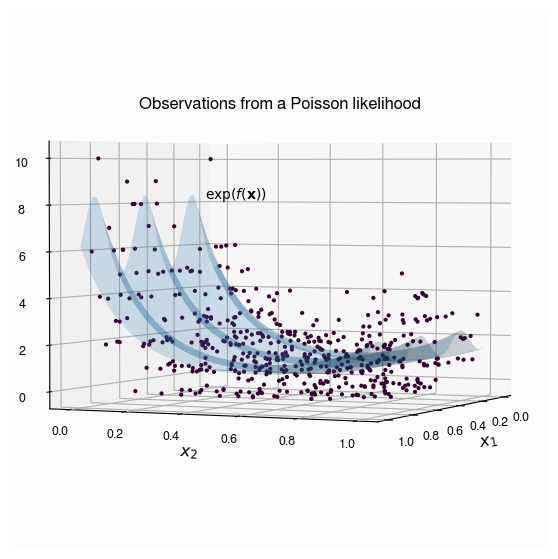

In [9]:
# Plot 4

# params
torch.manual_seed(88)

# samples
signal_var = 0.15
surf = torch.exp(signal_var*Y_surface[:,0])
sampling_dist = dist.Poisson(surf[idx])
samples = sampling_dist.sample_n(1).squeeze(0).numpy()

# Create figure
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf.reshape((N, N)).numpy(), alpha=.2)
ax.scatter(x1, x2, samples, color='#360332', alpha=1, s=4)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 5)
ax.set_xticklabels(ax.get_xticks().round(1), fontsize=fs)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=fs)
ax.set_zticklabels(np.int32(ax.get_zticks()), fontsize=fs)
ax.annotate("$\exp(f(\mathbf{x}))$", (-.028,.025), fontsize=10)
ax.view_init(-358, 25)

ax.set_title('Observations from a Poisson likelihood', y=.87)

fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "Poisson_likelihood.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
# Plot 4

# params
torch.manual_seed(88)

# samples
signal_var = 1
surf = torch.sigmoid(signal_var*Y_surface[:,0])
sampling_dist = dist.Bernoulli(surf[idx])
samples = sampling_dist.sample_n(1).squeeze(0).numpy()

# Create figure
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf.reshape((N, N)).numpy(), alpha=.20)
ax.scatter(x1, x2, samples, color='#360332', alpha=1, s=4)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
# print(ax.get_zlim())
ax.set_zlim(0, 1)
ax.set_xticklabels(ax.get_xticks().round(1), fontsize=fs)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=fs)
ax.set_zticklabels(ax.get_zticks().round(2), fontsize=fs)
ax.annotate("${logit}^{-1}(f(\mathbf{x}))$", (.062,.010), fontsize=10)
ax.view_init(-345, 80)

ax.set_title('Observations from a Bernoulli likelihood', y=.95)

fig.tight_layout()

fig.savefig(os.path.join(save_image_path, "Bernoulli_likelihood.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
# Plot 4

# params
torch.manual_seed(88)

# samples
signal_var = .28
surf = signal_var*Y_surface[:,0]
cutpoints = torch.tensor([.1, .85, 1.6])
sampling_dist = dist.OrderedLogistic(surf[idx], cutpoints)
samples = sampling_dist.sample_n(1).squeeze(0).numpy()

# Create figure
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf.reshape((N, N)).numpy(), alpha=.20)
ax.scatter(x1, x2, samples, color='#360332', alpha=1, s=4)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 1)
ax.set_zticks([0,1,2,3])
ax.set_xticklabels(ax.get_xticks().round(1), fontsize=fs)
ax.set_yticklabels(ax.get_yticks().round(1), fontsize=fs)
ax.set_zticklabels(ax.get_zticks().round(2), fontsize=fs)
ax.annotate("$f(\mathbf{x})$", (.072,-.022), fontsize=10)
ax.view_init(-358, 50)

ax.set_title('Observations from an Ordered logstic', y=.89)

fig.tight_layout()

fig.savefig(os.path.join(save_image_path, "Ordered_logistic.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
# Plot 2

# Create figure
fig = plt.figure(figsize=(7,7))

# Plot 2
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=.2)
ax2.scatter(x1, x2, samples2, color='#360332', alpha=1, s=4) 

# for i in line_indices:
#     ax2.plot([x1[i], x1[i]], [x2[i], x2[i]], [samples2[i], z_surface[i]], color='red', lw=.55, ls="--")

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# ax2.set_zlabel("f(x)", labelpad=-2.5)
# ax2.set_zlim(-.8, 1.6)
ax2.set_xticklabels(ax2.get_xticks().round(1), fontsize=fs)
ax2.set_yticklabels(ax2.get_yticks().round(1), fontsize=fs)
ax2.set_zticklabels(ax2.get_zticks().round(1), fontsize=fs)
ax2.annotate("$f(\mathbf{x})$", (.068,-.001), fontsize=10)
# ax2.view_init(*view_init)
ax2.view_init(-358, 25)
# ax2.grid(False)
# ax2.set_xticks([0, 1])
# ax2.set_yticks([0, 1])
# ax2.set_zticks([])
ax2.set_title('Observations from a fixed noise Gaussian likelihood', y=.87)

fig.tight_layout()

fig.savefig(os.path.join(save_image_path, "Gaussian_likelihood.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
# Plot 4

# params
torch.manual_seed(88)
fs_title = 12

# samples
signal_var = 0.15
surf = torch.exp(signal_var*Y_surface[:,0])
sampling_dist = dist.Poisson(surf[idx])
samples = sampling_dist.sample_n(1).squeeze(0).numpy()

# Create figure
fig = plt.figure(figsize=(14,52))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf.reshape((N, N)).numpy(), alpha=.2)
ax1.scatter(x1, x2, samples, color='#360332', alpha=1, s=4)

ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 5)
ax1.set_xticklabels(ax1.get_xticks().round(1), fontsize=fs)
ax1.set_yticklabels(ax1.get_yticks().round(1), fontsize=fs)
ax1.set_zticklabels(np.int32(ax1.get_zticks()), fontsize=fs)
ax1.annotate("$\exp(f(\mathbf{x}))$", (-.028,.025), fontsize=10)
ax1.view_init(-358, 25)

ax1.set_title('Observations from a \n Poisson likelihood', y=.87, fontsize=fs_title)

# fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "Poisson_likelihood.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')


# Plot 4

# params
torch.manual_seed(88)

# samples
signal_var = 1
surf = torch.sigmoid(signal_var*Y_surface[:,0])
sampling_dist = dist.Bernoulli(surf[idx])
samples = sampling_dist.sample_n(1).squeeze(0).numpy()

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf.reshape((N, N)).numpy(), alpha=.20)
ax2.scatter(x1, x2, samples, color='#360332', alpha=1, s=4)

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# print(ax.get_zlim())
ax2.set_zlim(0, 1)
ax2.set_xticklabels(ax2.get_xticks().round(1), fontsize=fs)
ax2.set_yticklabels(ax2.get_yticks().round(1), fontsize=fs)
ax2.set_zticklabels(ax2.get_zticks().round(2), fontsize=fs)
ax2.annotate("${logit}^{-1}(f(\mathbf{x}))$", (.062,.010), fontsize=10)
ax2.view_init(-345, 80)

ax2.set_title('Observations from a \n Bernoulli likelihood', y=.92, fontsize=fs_title)




##


# Plot 4

# params
torch.manual_seed(88)

# samples
signal_var = .28
surf = signal_var*Y_surface[:,0]
cutpoints = torch.tensor([.1, .85, 1.6])
sampling_dist = dist.OrderedLogistic(surf[idx], cutpoints)
samples = sampling_dist.sample_n(1).squeeze(0).numpy()

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf.reshape((N, N)).numpy(), alpha=.20)
ax3.scatter(x1, x2, samples, color='#360332', alpha=1, s=4)

ax3.set_xlabel("$x_1$")
ax3.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 1)
ax3.set_zticks([0,1,2,3])
ax3.set_xticklabels(ax3.get_xticks().round(1), fontsize=fs)
ax3.set_yticklabels(ax3.get_yticks().round(1), fontsize=fs)
ax3.set_zticklabels(ax3.get_zticks().round(2), fontsize=fs)
ax3.annotate("$f(\mathbf{x})$", (.072,-.022), fontsize=10)
ax3.view_init(-358, 50)

ax3.set_title('Observations from an \n Ordered logstic', y=.87, fontsize=fs_title)




###



# Plot 2


# Plot 2
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=.2)
ax4.scatter(x1, x2, samples2, color='#360332', alpha=1, s=4) 

# for i in line_indices:
#     ax2.plot([x1[i], x1[i]], [x2[i], x2[i]], [samples2[i], z_surface[i]], color='red', lw=.55, ls="--")

ax4.set_xlabel("$x_1$")
ax4.set_ylabel("$x_2$")
# ax2.set_zlabel("f(x)", labelpad=-2.5)
# ax2.set_zlim(-.8, 1.6)
ax4.set_xticklabels(ax4.get_xticks().round(1), fontsize=fs)
ax4.set_yticklabels(ax4.get_yticks().round(1), fontsize=fs)
ax4.set_zticklabels(ax4.get_zticks().round(1), fontsize=fs)
ax4.annotate("$f(\mathbf{x})$", (.068,-.001), fontsize=10)
# ax2.view_init(*view_init)
ax4.view_init(-358, 25)
# ax2.grid(False)
# ax2.set_xticks([0, 1])
# ax2.set_yticks([0, 1])
# ax2.set_zticks([])
ax4.set_title('Observations from a fixed \n noise Gaussian likelihood', y=.87, fontsize=fs_title)

fig.tight_layout()

fig.subplots_adjust(wspace=-.0, hspace=-.859)

# fig.savefig(os.path.join(save_image_path, "chained_GP_likelihoods.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

#### MOGP

##### Use HetMOGP model but set it to Gaussian likelihoods with 5 outcomes. 

In [ ]:
N = 100
D = 1

train_y = torch.empty((N,))
X = torch.linspace(0,1, N)

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        # 'covar_module.outputscale': torch.tensor(5),
        'covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(1.),
        'covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(92.),
        'covar_module.base_kernel.kernels.0.period_length': torch.tensor(.35),
        'mean_module.constant': torch.tensor(5.2)
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        # 'covar_module.outputscale': torch.tensor(8.),
        'covar_module.base_kernel.lengthscale': torch.tensor(.6),
        'mean_module.constant': torch.tensor(7)
    }, 
]

# initialise the m1
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = ScaleKernel(ProductKernel(
    PeriodicKernel(),
    RBFKernel()))
m1 = ExactGP(train_x=X, train_y=train_y, likelihood=likelihood1, kernel=kernel1)
m1.initialize(**hypers[0])

# initialise the m2
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
kernel2 = ScaleKernel(RBFKernel())
m2 = ExactGP(train_x=X, train_y=train_y, likelihood=likelihood2, kernel=kernel2)
m2.initialize(**hypers[1])

ilf = torch.empty((N, 2))

m1.eval()
torch.manual_seed(55)
with gpytorch.settings.prior_mode(True):
    ilf[:,0] = m1(X).sample()

m2.eval()
torch.manual_seed(27)
with gpytorch.settings.prior_mode(True):
    ilf[:,1] = m2(X).sample()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
color = "#360332"
ax[0].plot(X, ilf[:,0], color=color, lw=2.5)
ax[1].plot(X, ilf[:,1], color=color, lw=2.5)
ax[0].set_title("$u_1$ with $k_1 =$ SE x Per", fontsize=16)
ax[1].set_title("$u_2$ with $k_2 =$ SE", fontsize=16)
ax[0].set_ylabel(f'$u_1$', fontsize=18)  # Add the y label using LaTeX
ax[0].tick_params(axis='both', which='major', labelsize=12)  # Adjust the size of the ticks
ax[1].set_ylabel(f'$u_2$', fontsize=18)  # Add the y label using LaTeX
ax[1].tick_params(axis='both', which='major', labelsize=12)  # Adjust the size of the ticks
fig.suptitle("ILF: $u_1, u_2$", fontsize=17, weight="bold")
ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])

fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "ILFs.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
A = torch.tensor([
    [2.,-1.], # a_1
    [1., -.5], # a_2 = .5 * a_1
    [-2., 1.], # a_3 = -1 * a_1
    [-.05, -.01], # non-corr
    [0, 1] # non-corr
]).T
A

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(4, 4))

# Set the limits of the plot
ax.set_xlim([-3, 3])
ax.set_ylim([-1.5, 1.5])

# Plot the vectors

for i in range(A.shape[1]):
    ax.quiver(0, 0, A[0,i], A[1,i], angles='xy', scale_units='xy', scale=1, color="k", alpha=1, width=.005, headwidth=8, headlength=8, headaxislength=7)
    ax.annotate(f'$a_{{{i+1},.}}$', (A[0,i], A[1,i]), textcoords="offset points", ha='left', fontsize=10,xytext=(4,4))

ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="k", lw=.5)
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color="k", lw=.5)
ax.tick_params("both", labelsize=9)
ax.set_xlabel(f"$a_{{.,1}}$")
ax.set_ylabel(f"$a_{{.,2}}$")

# Add a grid
# ax.grid(linewidth=.25)

# Show the plot
fig.suptitle("MOGP LMC coefficients", y=.95, weight="bold")
plt.show()

# fig.savefig(os.path.join(save_image_path, "mogp_lmc.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')


In [ ]:
torch.manual_seed(55)
sd = torch.tensor([.03, .05, .01, .3, .08])
lpf = ilf @ A
y_dist = dist.Normal(lpf, sd)
Y = y_dist.sample_n(1).squeeze(0)


In [ ]:
train_idx, test_idx = torch.utils.data.random_split(X, [.5, .5], \
    generator=torch.Generator().manual_seed(80))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx]
test_x = X[test_idx]
train_y = Y[train_idx,:]
test_y = Y[test_idx,:]

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6))

# Define the colors
color = "#360332"
color_test = "#360332"
color_pred = "#c989c4"

# Define the sizes and alpha
size = 25
alpha = 1

# Plot the data
ax[0,0].scatter(train_x, train_y[:,0], s=size, color=color_test, alpha=alpha, edgecolor='white')
ax[0,0].set_ylabel('$y_1$', fontsize=10)
ax[0,1].scatter(train_x, train_y[:,1], s=size, color=color_test, alpha=alpha, edgecolor='white')
ax[0,1].set_ylabel('$y_2$', fontsize=10)
ax[1,0].scatter(train_x, train_y[:,2], s=size, color=color_test, alpha=alpha, edgecolor='white')
ax[1,0].set_ylabel('$y_3$', fontsize=10)
ax[2,0].scatter(train_x, train_y[:,3], s=size, color=color_test, alpha=alpha, edgecolor='white')
ax[2,0].set_ylabel('$y_4$', fontsize=10)
ax[2,1].scatter(train_x, train_y[:,4], s=size, color=color_test, alpha=alpha, edgecolor='white')
ax[2,1].set_ylabel('$y_5$', fontsize=10)
ax[1,1].axis("off")

# Adjust the size of the ticks
for i in range(3):
    for j in range(2):
        ax[i,j].tick_params(axis='both', which='major', labelsize=8)
        
fig.suptitle("Example data", fontsize=14)
fig.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

fig.savefig(os.path.join(save_image_path, "MOGP_data.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')


In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, neg_elbo):
        if neg_elbo < self.min_validation_loss:
            self.min_validation_loss = neg_elbo
            self.counter = 0
        elif neg_elbo > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [424]:
def train_model(model, sd_input=True, plot=False):
    pyro.set_rng_seed(88)
    pyro.clear_param_store()

    num_iter = 2000 
    num_particles = 10

    lrd_num_iter = 700
    initial_lr = 1e-1
    final_lr = 1e-3
    gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
    lrd = gamma ** (1 / lrd_num_iter) # learning rate decay

    optimizer = pyro.optim.ClippedAdam({
        'lr': initial_lr, 
        'lrd': lrd,
        'betas': (0.95, 0.999),
        'clip_norm': 2.5,
        # 'clip_norm': 5.0,
        # 'weight_decay': .01,
        })


    elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

    model.train()
    iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
    loss_array = np.zeros(num_iter)
    early_stopper = EarlyStopper(patience=80, min_delta=0)
    iterations_to_converge = 0
    for i in iterator:
        model.zero_grad()
        if sd_input:
            loss = svi.step(x=train_x, y=train_y, sd=sd)
        else:
            loss = svi.step(x=train_x, y=train_y)
        loss_array[i] = loss     
        iterator.set_postfix(loss=loss)
        if early_stopper.early_stop(loss) and i >= 500:
                iterations_to_converge = i
                break
    
    if plot:
        fig, ax = plt.subplots(figsize=(7,4))
        loss_start = 100
        ax.plot(np.arange(0, i-100), loss_array[loss_start:i])
        ax.set_xlabel(r"iteration", fontdict={'fontsize':8})
        ax.set_ylabel(r"scaled neg ELBO", fontdict={'fontsize':8})
        ax.set_title(r"Loss function = neg ELBO scaled", fontsize=10);
        fig.tight_layout()

In [ ]:
likelihoods = ["Normal", "Normal", "Normal", "Normal", "Normal"]
batch_shape=torch.Size([1])
kernels1 = [
    ScaleKernel(ProductKernel(RBFKernel(batch_shape=batch_shape), PeriodicKernel(batch_shape=batch_shape))),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels2 = [
    ScaleKernel(ProductKernel(RBFKernel(batch_shape=batch_shape), PeriodicKernel(batch_shape=batch_shape))),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels3 = [
    ScaleKernel(ProductKernel(RBFKernel(batch_shape=batch_shape), PeriodicKernel(batch_shape=batch_shape))),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
active_dims1 = [[0] for _ in range(2)]
active_dims2 = [[0] for _ in range(4)]
active_dims3 = [[0] for _ in range(8)]
lmc_prior = False
if lmc_prior:
    lmc_coefficients_prior = HorseshoePrior(.5)
else:
    lmc_coefficients_prior = None
model1 = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels1, 
                active_dims=active_dims1, num_inducing=50, sd=sd,
                lmc_coefficients_prior=lmc_coefficients_prior)
model2 = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels2, 
                active_dims=active_dims2, num_inducing=50, sd=sd,
                lmc_coefficients_prior=lmc_coefficients_prior)
model3 = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels3, 
                active_dims=active_dims3, num_inducing=50, sd=sd,
                lmc_coefficients_prior=lmc_coefficients_prior)

In [ ]:
train_model(model1)
train_model(model2)
train_model(model3)

In [ ]:
model2.variational_strategy.lmc_coefficients

In [ ]:
def get_predictions_mogp_example(model, x, num_samples=100):
    predictive_dist = Predictive(model.model, guide=model.guide, num_samples=num_samples)
    predictions = predictive_dist(x, None, sd=sd)
    y0_pred = predictions["hmogp.y_0"][0].squeeze(0).cpu().numpy()
    y1_pred = predictions['hmogp.y_1'][0].squeeze(0).cpu().numpy()
    y2_pred = predictions['hmogp.y_2'][0].squeeze(0).cpu().numpy()
    y3_pred = predictions['hmogp.y_3'][0].squeeze(0).cpu().numpy()
    y4_pred = predictions['hmogp.y_4'][0].squeeze(0).cpu().numpy()
    f_samples = predictions["hmogp.f(x)"].cpu()
    y_pred = np.vstack([y0_pred, y1_pred, y2_pred, y3_pred, y4_pred]).T
    
    return y_pred, f_samples

In [ ]:
y_pred1, f_samples1 = get_predictions_mogp_example(model1, train_x)
y_pred2, f_samples2 = get_predictions_mogp_example(model2, train_x)
y_pred3, f_samples3 = get_predictions_mogp_example(model3, train_x)

y_pred1_test, f_samples1_test = get_predictions_mogp_example(model1, test_x)
y_pred2_test, f_samples2_test = get_predictions_mogp_example(model2, test_x)
y_pred3_test, f_samples3_test = get_predictions_mogp_example(model3, test_x)

In [ ]:
def plot_ppc1(y_pred, x, y, title, mogp=True, savefig=False, **kwargs):
    fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(10,6), sharex=True)

    for i in range(5):
        for j in range(3):
            
            color_test = "#360332"
            if mogp:
                color = "#880E4F"
            else:
                color = "#2081BB"
            size = 25
            alpha = 1
                
            ax[i,j].scatter(x, y[:,i], alpha = alpha, label='Test data', s=size, color=color_test, edgecolor='white')
            ax[i,j].scatter(x, y_pred[j][:,i], alpha = .6, label='Posterior predictions', s=15, color=color, marker="x")
            ax[i,j].set_ylabel(f'$y_{i+1}$', fontsize=10)  # Add the y label using LaTeX
            ax[i,j].tick_params(axis='both', which='major', labelsize=8)  # Adjust the size of the ticks
            
            if (i in [4]) and (j == 1):  # Add the legend to the first subplot only
                ax[i,j].legend(fontsize=8)  # Adjust the size of the legend font

    ax[0,0].set_title("n_kernels = 2", fontsize=12)
    ax[0,1].set_title("n_kernels = 4", fontsize=12)
    ax[0,2].set_title("n_kernels = 8", fontsize=12)

    fig.suptitle(title, fontsize=14, weight="bold")

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()

    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4] == ".png") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
plot_ppc1([y_pred1_test, y_pred2_test, y_pred3_test], test_x, test_y, "MOGP with periodic kernel")

In [ ]:
likelihoods = ["Normal", "Normal", "Normal", "Normal", "Normal"]
batch_shape=torch.Size([1])
kernels4 = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels5 = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels6 = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
active_dims4 = [[0] for _ in range(2)]
active_dims5 = [[0] for _ in range(4)]
active_dims6 = [[0] for _ in range(8)]
lmc_prior = False
if lmc_prior:
    lmc_coefficients_prior = HorseshoePrior(.5)
else:
    lmc_coefficients_prior = None
model4 = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels4, 
                active_dims=active_dims4, num_inducing=50, sd=sd,
                lmc_coefficients_prior=lmc_coefficients_prior)
model5 = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels5, 
                active_dims=active_dims5, num_inducing=50, sd=sd,
                lmc_coefficients_prior=lmc_coefficients_prior)
model6 = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels6, 
                active_dims=active_dims6, num_inducing=50, sd=sd,
                lmc_coefficients_prior=lmc_coefficients_prior)

In [ ]:
train_model(model4)
train_model(model5)
train_model(model6)

In [ ]:
y_pred4, f_samples4 = get_predictions_mogp_example(model4, train_x)
y_pred5, f_samples5 = get_predictions_mogp_example(model5, train_x)
y_pred6, f_samples6 = get_predictions_mogp_example(model6, train_x)

y_pred4_test, f_samples4_test = get_predictions_mogp_example(model4, test_x)
y_pred5_test, f_samples5_test = get_predictions_mogp_example(model5, test_x)
y_pred6_test, f_samples6_test = get_predictions_mogp_example(model6, test_x)

In [ ]:
plot_ppc1([y_pred4_test, y_pred5_test, y_pred6_test], test_x, test_y, "MOGP without periodic kernel")

In [ ]:
likelihoods = ["Normal", "Normal", "Normal", "Normal", "Normal"]
batch_shape=torch.Size([1])
kernels1 = [
    ScaleKernel(ProductKernel(RBFKernel(batch_shape=batch_shape), PeriodicKernel(batch_shape=batch_shape))),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels2 = [
    ScaleKernel(ProductKernel(RBFKernel(batch_shape=batch_shape), PeriodicKernel(batch_shape=batch_shape))),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels3 = [
    ScaleKernel(ProductKernel(RBFKernel(batch_shape=batch_shape), PeriodicKernel(batch_shape=batch_shape))),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
active_dims1 = [[0] for _ in range(2)]
active_dims2 = [[0] for _ in range(4)]
active_dims3 = [[0] for _ in range(8)]
lmc_prior = False
if lmc_prior:
    lmc_coefficients_prior = HorseshoePrior(.5)
else:
    lmc_coefficients_prior = None
    
independent_outputs = True

model_list1 = []
model_list2 = []
model_list3 = []
num_lpf_list = [1, 1, 1, 1, 1]
for i, likelihood, num_lpf in zip(np.arange(len(num_lpf_list)), likelihoods, num_lpf_list):
    
    m1 = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], kernels=kernels1, 
                    active_dims=active_dims1, num_inducing=50, sd=sd[i],
                    lmc_coefficients_prior=lmc_coefficients_prior)
    m2 = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], kernels=kernels2, 
                    active_dims=active_dims2, num_inducing=50, sd=sd[i],
                    lmc_coefficients_prior=lmc_coefficients_prior)
    m3 = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], kernels=kernels3,
                    active_dims=active_dims3, num_inducing=50, sd=sd[i],
                    lmc_coefficients_prior=lmc_coefficients_prior)
    
    model_list1.append(m1)
    model_list2.append(m2)
    model_list3.append(m3)
    
model_list_of_list = []
model_list_of_list.extend([model_list1, model_list2, model_list3])

In [ ]:
pyro.set_rng_seed(88)
pyro.clear_param_store()

num_iter = 2000 
num_particles = 10

lrd_num_iter = 700
initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / lrd_num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999),
    'clip_norm': 2.5,
    # 'clip_norm': 5.0,
    # 'weight_decay': .01,
    })

iterations_to_converge = 0
# dims = [list(range(0,5))]
# loss_array = np.zeros((num_iter,5))
for m_list in model_list_of_list:
    for q, m in enumerate(m_list):
        pyro.clear_param_store()
        early_stopper = EarlyStopper(patience=50, min_delta=0)
        elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
        svi = pyro.infer.SVI(m.model, m.guide, optimizer, elbo)
        # print("dim =", q)
        m.train()
        # iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
        for i in range(num_iter):
            m.zero_grad()
            loss = svi.step(x=train_x, y=train_y[...,q].unsqueeze(-1), sd=[sd[q]])
            # loss_array[i,q] = loss
            # iterator.set_postfix(loss=loss)
            if early_stopper.early_stop(loss) and i >= 100:
                iterations_to_converge += i
                break

In [ ]:
def get_predictions_indgp_example(model_list, x, num_samples=100):
    y_pred_ind = []
    f_samples_ind = []
    for i, model in enumerate(model_list):
        predictive_dist = Predictive(model.model, guide=model.guide, num_samples=num_samples)
        predictions = predictive_dist(x, None, sd=[sd[i]])
        pred = predictions[f"hmogp.y_0"][0].squeeze(0).cpu().numpy()
        y_pred_ind.append(pred)
        f_samples_ind.append(predictions["hmogp.f(x)"].cpu())
    y_pred_ind = np.vstack(y_pred_ind)
    y_pred_ind = y_pred_ind.T
    f_samples_ind = torch.concatenate(f_samples_ind, axis=-1)
    return y_pred_ind, f_samples_ind

In [ ]:
y_pred1_ind, f_samples1_ind = get_predictions_indgp_example(model_list1, train_x)
y_pred2_ind, f_samples2_ind = get_predictions_indgp_example(model_list2, train_x)
y_pred3_ind, f_samples3_ind = get_predictions_indgp_example(model_list3, train_x)


y_pred1_ind_test, f_samples1_ind_test = get_predictions_indgp_example(model_list1, test_x)
y_pred2_ind_test, f_samples2_ind_test = get_predictions_indgp_example(model_list2, test_x)
y_pred3_ind_test, f_samples3_ind_test = get_predictions_indgp_example(model_list3, test_x)

In [ ]:
plot_ppc1([y_pred1_ind_test, y_pred2_ind_test, y_pred3_ind_test], test_x, test_y, mogp=False, title="Independent GPs with periodic kernel")

In [ ]:
# Create a 5x5 correlation matrix
corr_matrix_train = np.corrcoef(train_y.numpy().T)
corr_matrix_pred = np.corrcoef(y_pred3.T)
corr_matrix_pred_ind = np.corrcoef(y_pred3_ind.T)
annot_size = 15

# Create a mask to only show the lower triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix_train, dtype=bool))

# Create the heatmap
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))  # Adjust the size for compactness
cbar_kws = {"shrink": 1, 'ticks' : [-.5, 0, .5], 'pad': 0.02}  # Adjust the colorbar ticks and the gap

# First heatmap
sns.heatmap(corr_matrix_train, mask=mask, cmap='RdBu', center=0, annot=True, fmt=".2f", 
            linewidths=0.5, cbar=False, ax=ax1, annot_kws={"size": annot_size})
ax1.set_title('Training data correlation', fontsize=16, weight="bold")
ax1.set_xticklabels([f'$y_{i+1}$' for i in range(5)], fontsize=8)  # Use LaTeX for the x tick labels
ax1.set_yticklabels([f'$y_{i+1}$' for i in range(5)], fontsize=8)  # Use LaTeX for the y tick labels
ax1.tick_params(axis='both', which='major', labelsize=12)

# Second heatmap
sns.heatmap(corr_matrix_pred, mask=mask, cmap='RdBu', center=0, annot=True, fmt=".2f", 
            linewidths=0.5, cbar=False, ax=ax2, annot_kws={"size": annot_size})
ax2.set_title('MOGP predicted data', fontsize=16, weight="bold")
ax2.set_xticklabels([f'$y_{i+1}$' for i in range(5)], fontsize=8)  # Use LaTeX for the x tick labels
ax2.set_yticklabels([f'$y_{i+1}$' for i in range(5)], fontsize=8)  # Use LaTeX for the y tick labels
ax2.tick_params(axis='both', which='major', labelsize=12)


# Third heatmap
sns.heatmap(corr_matrix_pred_ind, mask=mask, cmap='RdBu', center=0, annot=True, fmt=".2f", 
            linewidths=0.5, cbar_kws=cbar_kws, ax=ax3, annot_kws={"size": annot_size})
ax3.set_title('Independent GPs predicted data', fontsize=16, weight="bold")
ax3.set_xticklabels([f'$y_{i+1}$' for i in range(5)], fontsize=8)  # Use LaTeX for the x tick labels
ax3.set_yticklabels([f'$y_{i+1}$' for i in range(5)], fontsize=8)  # Use LaTeX for the y tick labels
ax3.tick_params(axis='both', which='major', labelsize=12)

# Get the colorbar object from the Seaborn heatmap
cbar = ax3.collections[0].colorbar
# Set the colorbar label font size
cbar.ax.tick_params(labelsize=12)

# Adjust the layout to prevent overlapping
# ax2.set_suptitle("Independent GPs", fontsize=14, weight="bold")
fig.tight_layout()

# Save the figure
fig.savefig(os.path.join(save_image_path, "heatmap_mogp_ind.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

plt.show()


In [ ]:
likelihoods = ["Normal", "Normal", "Normal", "Normal", "Normal"]
batch_shape=torch.Size([1])
kernels1 = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels2 = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
kernels3 = [
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
    ScaleKernel(RBFKernel(batch_shape=batch_shape)),
]
active_dims1 = [[0] for _ in range(2)]
active_dims2 = [[0] for _ in range(4)]
active_dims3 = [[0] for _ in range(8)]
lmc_prior = False
if lmc_prior:
    lmc_coefficients_prior = HorseshoePrior(.5)
else:
    lmc_coefficients_prior = None
    
independent_outputs = True

model_list4 = []
model_list5 = []
model_list6 = []
num_lpf_list = [1, 1, 1, 1, 1]
for i, likelihood, num_lpf in zip(np.arange(len(num_lpf_list)), likelihoods, num_lpf_list):
    
    m4 = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], kernels=kernels1, 
                    active_dims=active_dims1, num_inducing=50, sd=sd[i],
                    lmc_coefficients_prior=lmc_coefficients_prior)
    m5 = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], kernels=kernels2, 
                    active_dims=active_dims2, num_inducing=50, sd=sd[i],
                    lmc_coefficients_prior=lmc_coefficients_prior)
    m6 = HetMOGP(train_x, num_lpf=num_lpf, likelihoods=[likelihood], kernels=kernels3,
                    active_dims=active_dims3, num_inducing=50, sd=sd[i],
                    lmc_coefficients_prior=lmc_coefficients_prior)
    
    model_list4.append(m4)
    model_list5.append(m5)
    model_list6.append(m6)
    
model_list_of_list2 = []
model_list_of_list2.extend([model_list4, model_list5, model_list6])

In [ ]:
pyro.set_rng_seed(88)
pyro.clear_param_store()

num_iter = 2000 
num_particles = 10

lrd_num_iter = 700
initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / lrd_num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999),
    'clip_norm': 2.5,
    # 'clip_norm': 5.0,
    # 'weight_decay': .01,
    })

iterations_to_converge = 0
# dims = [list(range(0,5))]
# loss_array = np.zeros((num_iter,5))
for m_list in model_list_of_list2:
    for q, m in enumerate(m_list):
        pyro.clear_param_store()
        early_stopper = EarlyStopper(patience=50, min_delta=0)
        elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
        svi = pyro.infer.SVI(m.model, m.guide, optimizer, elbo)
        # print("dim =", q)
        m.train()
        # iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
        for i in range(num_iter):
            m.zero_grad()
            loss = svi.step(x=train_x, y=train_y[...,q].unsqueeze(-1), sd=[sd[q]])
            # loss_array[i,q] = loss
            # iterator.set_postfix(loss=loss)
            if early_stopper.early_stop(loss) and i >= 100:
                iterations_to_converge += i
                break

In [ ]:
y_pred4_ind, f_samples4_ind = get_predictions_indgp_example(model_list4, train_x)
y_pred5_ind, f_samples5_ind = get_predictions_indgp_example(model_list5, train_x)
y_pred6_ind, f_samples6_ind = get_predictions_indgp_example(model_list6, train_x)

y_pred4_ind_test, f_samples4_ind_test = get_predictions_indgp_example(model_list4, test_x)
y_pred5_ind_test, f_samples5_ind_test = get_predictions_indgp_example(model_list5, test_x)
y_pred6_ind_test, f_samples6_ind_test = get_predictions_indgp_example(model_list6, test_x)

In [ ]:
y_pred4_ind_test.shape

In [ ]:
plot_ppc1([y_pred4_ind_test, y_pred5_ind_test, y_pred6_ind_test], test_x, test_y, mogp=False, title="Independent GPs without periodic kernel")

In [ ]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [ ]:
def plot_ppc2(y_pred_mogp, y_pred_ind, f_samples_mogp, f_samples_ind, x, y, title, savefig=False, **kwargs):
    
    f_lower_mogp, f_mean_mogp, f_upper_mogp = percentiles_from_samples(f_samples_mogp)
    f_lower_ind, f_mean_ind, f_upper_ind = percentiles_from_samples(f_samples_ind)

    fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(10,6), sharex=True)

    for i in range(5):
        for j in range(3):
            
            color_test = "#360332"
            size = 25
            alpha = 1
            color_mogp = "#880E4F"
            color_ind = "#2081BB"
            
            if j in [0,1]:
                if j == 0:
                    y_pred = y_pred_ind
                    color = color_ind
                elif j == 1:
                    y_pred = y_pred_mogp
                    color = color_mogp
                    
                ax[i,j].scatter(x, y[:,i], alpha = 1, label='Test data', s=size, color=color_test, edgecolor="white")
                ax[i,j].scatter(x, y_pred[:,i], alpha = .7, label='Predictions', s=15, color=color, marker="x")
                ax[i,j].set_ylabel(f'$y_{i+1}$', fontsize=10)  # Add the y label using LaTeX
            else:
                idx = np.argsort(x)
                color = color_test
                ax[i,j].plot(X, lpf[:,i], color=color, lw=.75, label="True")
                
                ax[i,j].plot(x[idx], f_mean_mogp[idx,i], color=color_mogp, lw=.75, label="MOGP", ls="--")
                ax[i,j].fill_between(
                    x[idx], f_lower_mogp[idx,i],
                    f_upper_mogp[idx,i], alpha=0.1, color=color_mogp
                )
                
                ax[i,j].plot(x[idx], f_mean_ind[idx,i], color=color_ind, lw=.75, label="Ind-GP", ls="--")
                ax[i,j].fill_between(
                    x[idx], f_lower_ind[idx,i],
                    f_upper_ind[idx,i], alpha=0.1, color=color_ind
                )
                
                ax[i,j].set_ylabel(r'$\tilde{{f}}_{}$'.format(i+1), fontsize=10)  # Add the y label using LaTeX
                
            if (i == 4) and (j in [0,1,2]):  # Add the legend to the first subplot only
                ax[i,j].legend(fontsize=8)  # Adjust the size of the legend font
            ax[i,j].set_xlim([0,1])
            ax[i,j].tick_params(axis='both', which='major', labelsize=8)  # Adjust the size of the ticks

    ax[0,0].set_title("Independent GPs", fontsize=12)
    ax[0,1].set_title("MOGP", fontsize=12)
    ax[0,2].set_title("LPF", fontsize=12)

    fig.suptitle(title, fontsize=12)

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] == ".png") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
plot_ppc2(y_pred1_test, y_pred1_ind_test, f_samples1_test, f_samples1_ind_test, test_x, test_y, title=r"n_kernels=2 $\bf{with}$ periodic kernel", savefig=True, filename="mogp_ind_nkern2_periodic.png")

In [ ]:
plot_ppc2(y_pred2_test, y_pred2_ind_test, f_samples2_test, f_samples2_ind_test, test_x, test_y, title=r"n_kernels=4 $\bf{with}$ periodic kernel", savefig=True, filename="mogp_ind_nkern4_periodic.png")

In [ ]:
plot_ppc2(y_pred3_test, y_pred3_ind_test, f_samples3_test, f_samples3_ind_test, test_x, test_y, title=r"n_kernels=8 $\bf{with}$ periodic kernel", savefig=True, filename="mogp_ind_nkern8_periodic.png")

In [ ]:
plot_ppc2(y_pred4_test, y_pred4_ind_test, f_samples4_test, f_samples4_ind_test, test_x, test_y, title=r"n_kernels=2 $\bf{without}$ periodic kernel", savefig=True, filename="mogp_ind_nkern2_no_periodic.png")

In [ ]:
plot_ppc2(y_pred5_test, y_pred5_ind_test, f_samples5_test, f_samples5_ind_test, test_x, test_y, title=r"n_kernels=4 $\bf{without}$ periodic kernel", savefig=True, filename="mogp_ind_nkern4_no_periodic.png")

In [ ]:
plot_ppc2(y_pred6_test, y_pred6_ind_test, f_samples6_test, f_samples6_ind_test, test_x, test_y, title=r"n_kernels=8 $\bf{without}$ periodic kernel", savefig=True, filename="mogp_ind_nkern8_no_periodic.png")

In [ ]:
f_samples_mogp_periodic = [f_samples1_test, f_samples2_test, f_samples3_test]
f_samples_ind_periodic = [f_samples1_ind_test, f_samples2_ind_test, f_samples3_ind_test]

f_samples_mogp_no_periodic = [f_samples4_test, f_samples5_test, f_samples6_test]
f_samples_ind_no_periodic = [f_samples4_ind_test, f_samples5_ind_test, f_samples6_ind_test]

In [ ]:
def plot_ppc3(f_samples_mogp, f_samples_ind, x, title, savefig=False, **kwargs):
    
    f_lower_mogp = []
    f_mean_mogp = []
    f_upper_mogp = []
    f_lower_ind = []
    f_mean_ind = []
    f_upper_ind = []
    
    for i in range(len(f_samples_mogp)):
        lower_mogp, mean_mogp, upper_mogp = percentiles_from_samples(f_samples_mogp[i])
        lower_ind, mean_ind, upper_ind = percentiles_from_samples(f_samples_ind[i])
        f_lower_mogp.append(lower_mogp)
        f_mean_mogp.append(mean_mogp)
        f_upper_mogp.append(upper_mogp)
        f_lower_ind.append(lower_ind)
        f_mean_ind.append(mean_ind)
        f_upper_ind.append(upper_ind)

    fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(10,6), sharex=True)

    for i in range(5):
        for j in range(3):
            
            color_test = "#360332"
            color_mogp = "#880E4F"
            color_ind = "#2081BB"
            
            idx = np.argsort(x)
            ax[i,j].plot(X, lpf[:,i], color=color_test, lw=.75, label="True")
            
            ax[i,j].plot(x[idx], f_mean_mogp[j][idx,i], color=color_mogp, lw=.75, label="MOGP", ls="--")
            ax[i,j].fill_between(
                x[idx], f_lower_mogp[j][idx,i],
                f_upper_mogp[j][idx,i], alpha=0.1, color=color_mogp
            )
            
            ax[i,j].plot(x[idx], f_mean_ind[j][idx,i], color=color_ind, lw=.75, label="Ind-GP", ls="--")
            ax[i,j].fill_between(
                x[idx], f_lower_ind[j][idx,i],
                f_upper_ind[j][idx,i], alpha=0.1, color=color_ind
            )
            
            ax[i,j].set_ylabel(r'$\tilde{{f}}_{}$'.format(i+1), fontsize=10)  # Add the y label using LaTeX
                
            if (i in [4]) and (j in [1]):  # Add the legend to the first subplot only
                ax[i,j].legend(fontsize=8)  # Adjust the size of the legend font
            ax[i,j].set_xlim([0,1])
            ax[i,j].tick_params(axis='both', which='major', labelsize=8)  # Adjust the size of the ticks

    ax[0,0].set_title("n_kernels = 2", fontsize=12)
    ax[0,1].set_title("n_kernels = 4", fontsize=12)
    ax[0,2].set_title("n_kernels = 8", fontsize=12)

    fig.suptitle(title, fontsize=12)

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4] == ".png") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [ ]:
plot_ppc3(f_samples_mogp_periodic, f_samples_ind_periodic, test_x, title=r"LPF estimates $\bf{with}$ periodic kernel")

In [ ]:
plot_ppc3(f_samples_mogp_no_periodic, f_samples_ind_no_periodic, test_x, title=r"LPF estimates $\bf{without}$ periodic kernel")

#### HetMOGP

##### Extend Chained or Generalised GP example of 4 likelihoods with correlated LPFs. Use 2x ILFs. 1 of the ILFs are from the Chained or Generalised GP example. Introduce the 2nd ILFs.

In [953]:
N = 100
D = 2
train_x = torch.empty((N,D))
train_y = torch.empty((N,))

# create fixed hyperparameters

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(5),
        'covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(1.),
        'covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(92.),
        'covar_module.base_kernel.kernels.0.period_length': torch.tensor(.35),
        'mean_module.constant': torch.tensor(5.2)
    }, 
    # {
    #     'likelihood.noise_covar.noise': torch.tensor(1),
    #     'covar_module.outputscale': torch.tensor(8.),
    #     'covar_module.base_kernel.lengthscale': torch.tensor([9., .85]),
    #     'mean_module.constant': torch.tensor(5.2)
    # }
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(.25),
        'covar_module.base_kernel.lengthscale': torch.tensor([1., .75]),
        'mean_module.constant': torch.tensor(1.5)
    }, 
]

# initialise the m1
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = ScaleKernel(AdditiveKernel(
    PeriodicKernel(active_dims=[0]),
    RBFKernel(active_dims=[1])))
m1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood1, kernel=kernel1)
m1.initialize(**hypers[0])

# initialise the m2
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
kernel2 = ScaleKernel(RBFKernel(ard_num_dims=train_x.shape[-1]))
m2 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood2, kernel=kernel2)
m2.initialize(**hypers[1])

x1 = torch.linspace(0, 1, N)
x2 = torch.linspace(0, 1, N)

x1_grid, x2_grid = torch.meshgrid([x1, x2])
X_grid = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))

Y_surface = torch.empty((N**2,2))

m1.eval()
torch.manual_seed(55)
with gpytorch.settings.prior_mode(True):
    Y_surface[:,0] = m1(X_grid).sample()

m2.eval()
torch.manual_seed(49)
with gpytorch.settings.prior_mode(True):
    Y_surface[:,1] = m2(X_grid).sample()

<Axes: >

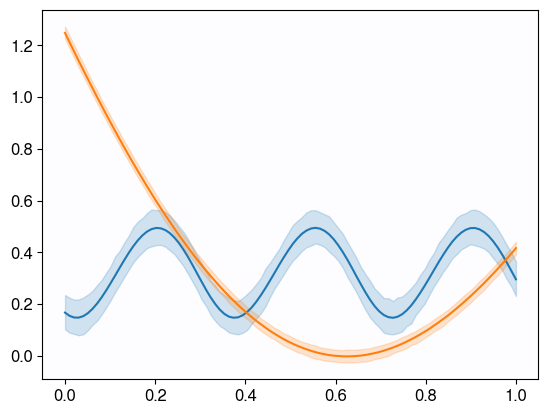

In [954]:
sns.lineplot(x=X_grid[:,0], y=Y_surface[:,0])
sns.lineplot(x=X_grid[:,1], y=Y_surface[:,0])

<Axes: >

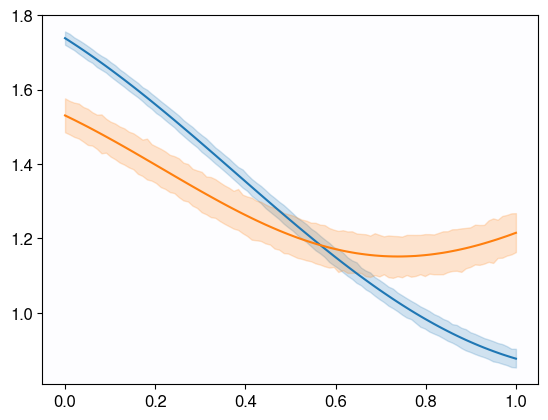

In [955]:
sns.lineplot(x=X_grid[:,0], y=Y_surface[:,1])
sns.lineplot(x=X_grid[:,1], y=Y_surface[:,1])

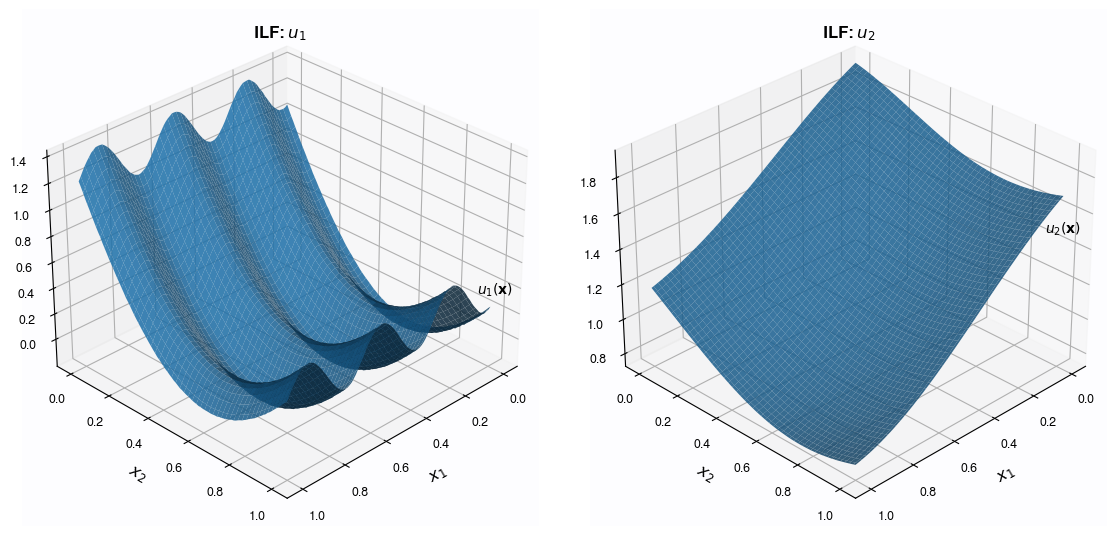

In [956]:
view_init = (-330, 45)
# increase signal

# Y_surface = Y_surface0.clone()
# Y_surface[...,0] = signal_var*Y_surface[...,0]

alpha = .85

fig = plt.figure(figsize=(14,7))
fs = 9
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,0].reshape((N, N)).numpy(), alpha=alpha)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
# ax1.set_zlabel("f(x)", labelpad=-2.5, fontsize=12)
# ax1.set_zlim(0, 17)
ax1.set_xticklabels(ax1.get_xticks().round(1), fontsize=fs)
ax1.set_yticklabels(ax1.get_yticks().round(1), fontsize=fs)
ax1.set_zticklabels(ax1.get_zticks().round(1), fontsize=fs)
ax1.annotate("$u_1(\mathbf{x})$", (.068,-.012), fontsize=10)
ax1.view_init(*view_init)
# ax1.grid(False)
# ax1.set_xticks([0, 1])
# ax1.set_yticks([0, 1])
# ax1.set_zticks([])
ax1.set_title('ILF: $u_1$', y=1.01, weight="bold")



ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid.numpy(), x2_grid.numpy(), Y_surface[:,1].reshape((N, N)).numpy(), alpha=alpha)
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# ax1.set_zlabel("f(x)", labelpad=-2.5, fontsize=12)
# ax1.set_zlim(0, 17)
ax2.set_xticklabels(ax2.get_xticks().round(1), fontsize=fs)
ax2.set_yticklabels(ax2.get_yticks().round(1), fontsize=fs)
ax2.set_zticklabels(ax2.get_zticks().round(1), fontsize=fs)
ax2.annotate("$u_2(\mathbf{x})$", (.068,.01), fontsize=10)
ax2.view_init(*view_init)
# ax1.grid(False)
# ax1.set_xticks([0, 1])
# ax1.set_yticks([0, 1])
# ax1.set_zticks([])
ax2.set_title('ILF: $u_2$', y=1.01, weight="bold")

fig.subplots_adjust(wspace=.1, hspace=-.859)

# fig.subplots_adjust(left=0.5, right=1000000, bottom=0.05, top=0.95)

fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "hetmogp_ilf.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [957]:
# signal_var_init = 10
# signal_var_y1 = signal_var_init*0.15
# signal_var_y2 = signal_var_init*1
# signal_var_y3 = signal_var_init*.28
# signal_var_y4 = signal_var_init*1

# signal_var_init = 1
# signal_var_y1 = signal_var_init*0.15
# signal_var_y2 = signal_var_init*-3
# signal_var_y3 = signal_var_init*.28
# signal_var_y4 = signal_var_init*-.35


A = torch.tensor([
    [-1.5,1], # a1
    [-1.5, 1], # a2 = identical to a1
    [.5, 1.5], # a3
    [3, 3],  # a4 # moderately correlated to a3
]).T
A

tensor([[-1.5000, -1.5000,  0.5000,  3.0000],
        [ 1.0000,  1.0000,  1.5000,  3.0000]])

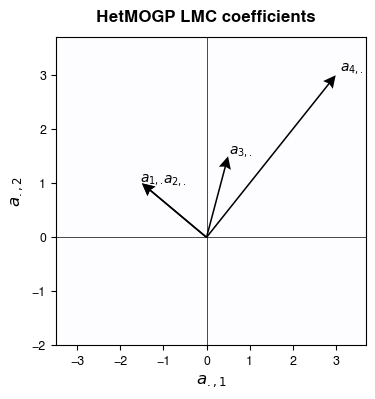

In [958]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(4, 4))

# Set the limits of the plot
ax.set_xlim([-3.5, 3.7])
ax.set_ylim([-2, 3.7])

# Plot the vectors
color = 'b'
for i in range(A.shape[1]):
    ax.quiver(0, 0, A[0,i], A[1,i], angles='xy', scale_units='xy', scale=1, color="k", alpha=1, width=.005, headwidth=8, headlength=8, headaxislength=7)
    if i >= 2:
        ax.annotate(f'$a_{{{i+1},.}}$', (A[0,i], A[1,i]), textcoords="offset points", ha='left', fontsize=10)
ax.annotate(f'$a_{{{1},.}}$', (A[0,0], A[1,0]), textcoords="offset points", ha='left', fontsize=10)
ax.annotate(f'$a_{{{2},.}}$', (A[0,0], A[1,0]), textcoords="offset points", ha='left', fontsize=10, xytext=(15, 0))
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="k", lw=.5)
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color="k", lw=.5)
ax.tick_params("both", labelsize=9)
ax.set_xlabel(f"$a_{{.,1}}$")
ax.set_ylabel(f"$a_{{.,2}}$")

# Add a grid
# ax.grid(linewidth=.25)

# Show the plot
fig.suptitle("HetMOGP LMC coefficients", y=.95, weight="bold")
plt.show()

# fig.savefig(os.path.join(save_image_path, "hetmogp_lmc.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [959]:
# params
n_samples = 500
torch.manual_seed(88)
idx = torch.randint(0,10000,(n_samples,))

x1 = x1_grid.flatten().numpy()[idx]
x2 = x2_grid.flatten().numpy()[idx]

# samples

# y1
raw_f11 = Y_surface @ A[:,0]
surf_11 = torch.exp(raw_f11)
f_11 = surf_11[idx]
dist_y1 = dist.Poisson(f_11)
y1 = dist_y1.sample_n(1).squeeze(0).numpy()

# y2
raw_f21 = Y_surface @ A[:,1]
surf_21 = torch.sigmoid(raw_f21)
f_21 = surf_21[idx]
dist_y2 = dist.Bernoulli(f_21)
y2 = dist_y2.sample_n(1).squeeze(0).numpy()

# y3
surf_31 = Y_surface @ A[:,2]
f_31 = surf_31[idx]
cutpoints = torch.tensor([.1, .85, 1.6])
dist_y3 = dist.OrderedLogistic(f_31, cutpoints)
y3 = dist_y3.sample_n(1).squeeze(0).numpy()

# y4
surf_41 = Y_surface @ A[:,3]
f_41 = surf_41[idx]
dist_y4 = dist.Normal(f_41, torch.tensor(3.))
y4 = dist_y4.sample_n(1).squeeze(0).numpy()

y_data = np.vstack([y1, y2, y3, y4]).T

# # Get the z values from the surface at the scatter points
# z_surface = Y_surface[idx,0].numpy()

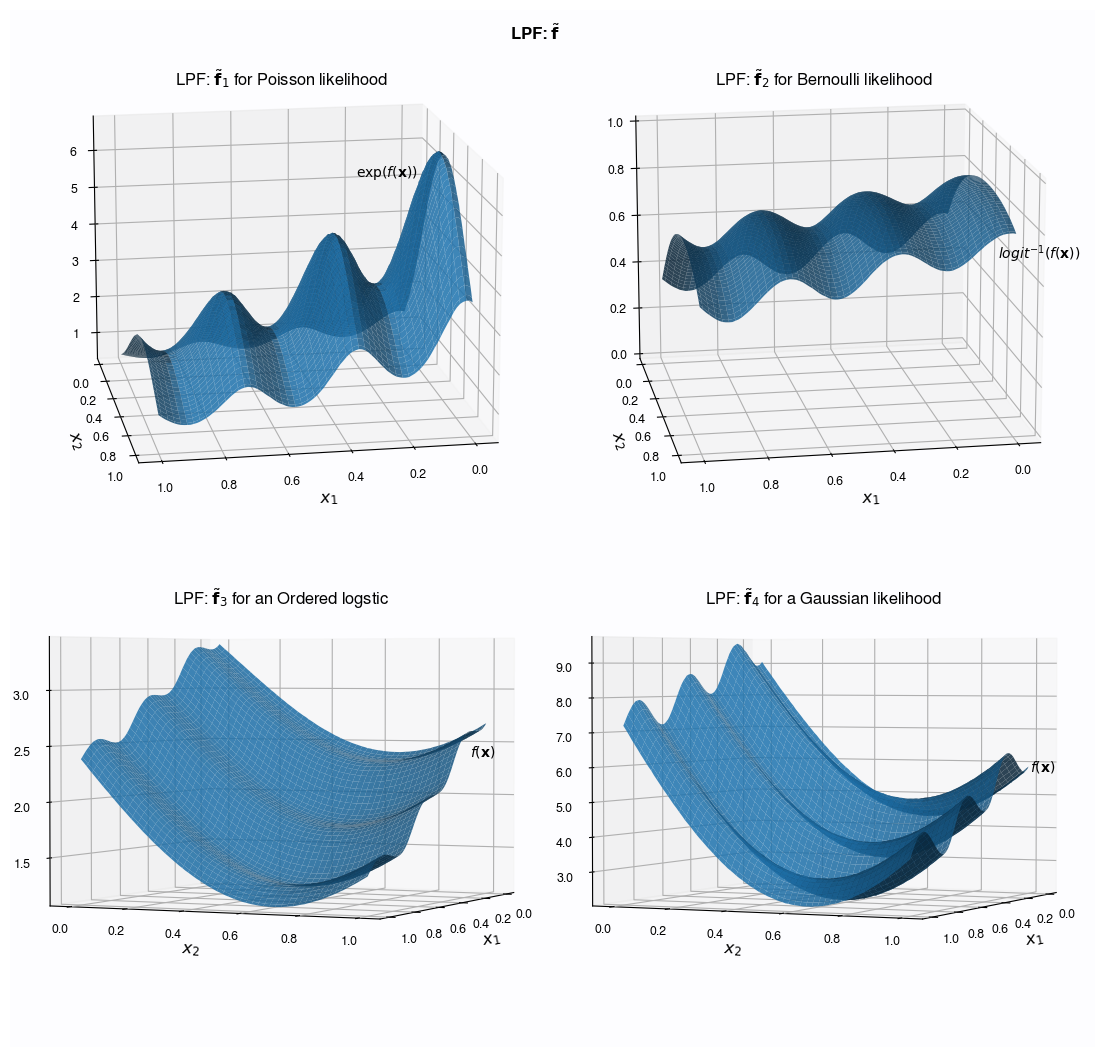

In [960]:
# Plot 4

fs_title = 12
alpha = .85

# Create figure
fig = plt.figure(figsize=(14,52))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_11.reshape((N, N)).numpy(), alpha=alpha)
# ax1.scatter(x1, x2, y1, color='#360332', alpha=1, s=4)

ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 5)
ax1.set_xticklabels(ax1.get_xticks().round(1), fontsize=fs)
ax1.set_yticklabels(ax1.get_yticks().round(1), fontsize=fs)
ax1.set_zticklabels(np.int32(ax1.get_zticks()), fontsize=fs)
ax1.annotate("$\exp(f(\mathbf{x}))$", (.023,.033), fontsize=10)
# ax1.view_init(-358, 25)
ax1.view_init(-345, 80)

ax1.set_title(r'LPF: $\tilde{\mathbf{f}}_1$ for Poisson likelihood', y=.92, fontsize=fs_title)

# fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "Poisson_likelihood.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')


# Plot 4

# params
torch.manual_seed(88)

# samples
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_21.reshape((N, N)).numpy(), alpha=alpha)
# ax2.scatter(x1, x2, y2, color='#360332', alpha=1, s=4)

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# print(ax.get_zlim())
ax2.set_zlim(0, 1)
ax2.set_xticklabels(ax2.get_xticks().round(1), fontsize=fs)
ax2.set_yticklabels(ax2.get_yticks().round(1), fontsize=fs)
ax2.set_zticklabels(ax2.get_zticks().round(2), fontsize=fs)
ax2.annotate("${logit}^{-1}(f(\mathbf{x}))$", (.057,.005), fontsize=10)
ax2.view_init(-345, 80)

ax2.set_title(r'LPF: $\tilde{\mathbf{f}}_2$ for Bernoulli likelihood', y=.92, fontsize=fs_title)




##


# Plot 4
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_31.reshape((N, N)).numpy(), alpha=alpha)
# ax3.scatter(x1, x2, y3, color='#360332', alpha=1, s=4)

ax3.set_xlabel("$x_1$")
ax3.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 1)
# ax3.set_zticks([0,1,2,3])
ax3.set_xticklabels(ax3.get_xticks().round(1), fontsize=fs)
ax3.set_yticklabels(ax3.get_yticks().round(1), fontsize=fs)
ax3.set_zticklabels(ax3.get_zticks().round(2), fontsize=fs)
ax3.annotate("$f(\mathbf{x})$", (.062,.004), fontsize=10)
# ax3.view_init(-358, 50)
ax3.view_init(-358, 25)

ax3.set_title(r'LPF: $\tilde{\mathbf{f}}_3$ for an Ordered logstic', y=.87, fontsize=fs_title)


###



# Plot 2


# Plot 2
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_41.reshape((N, N)).numpy(), alpha=alpha)
# ax4.scatter(x1, x2, y4, color='#360332', alpha=1, s=4) 

# for i in line_indices:
#     ax2.plot([x1[i], x1[i]], [x2[i], x2[i]], [samples2[i], z_surface[i]], color='red', lw=.55, ls="--")

ax4.set_xlabel("$x_1$")
ax4.set_ylabel("$x_2$")
# ax2.set_zlabel("f(x)", labelpad=-2.5)
# ax2.set_zlim(-.8, 1.6)
ax4.set_xticklabels(ax4.get_xticks().round(1), fontsize=fs)
ax4.set_yticklabels(ax4.get_yticks().round(1), fontsize=fs)
ax4.set_zticklabels(ax4.get_zticks().round(1), fontsize=fs)
ax4.annotate("$f(\mathbf{x})$", (.068,-.001), fontsize=10)
# ax2.view_init(*view_init)
ax4.view_init(-358, 25)
# ax4.view_init(-358, 50)
# ax2.grid(False)
# ax2.set_xticks([0, 1])
# ax2.set_yticks([0, 1])
# ax2.set_zticks([])
ax4.set_title(r'LPF: $\tilde{\mathbf{f}}_4$ for a Gaussian likelihood', y=.87, fontsize=fs_title)

fig.suptitle(r"LPF: $\tilde{\mathbf{f}}$", weight="bold", y=.592)

fig.tight_layout()

fig.subplots_adjust(wspace=-.0, hspace=-.859)

# fig.savefig(os.path.join(save_image_path, "hetmogp_lpf.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

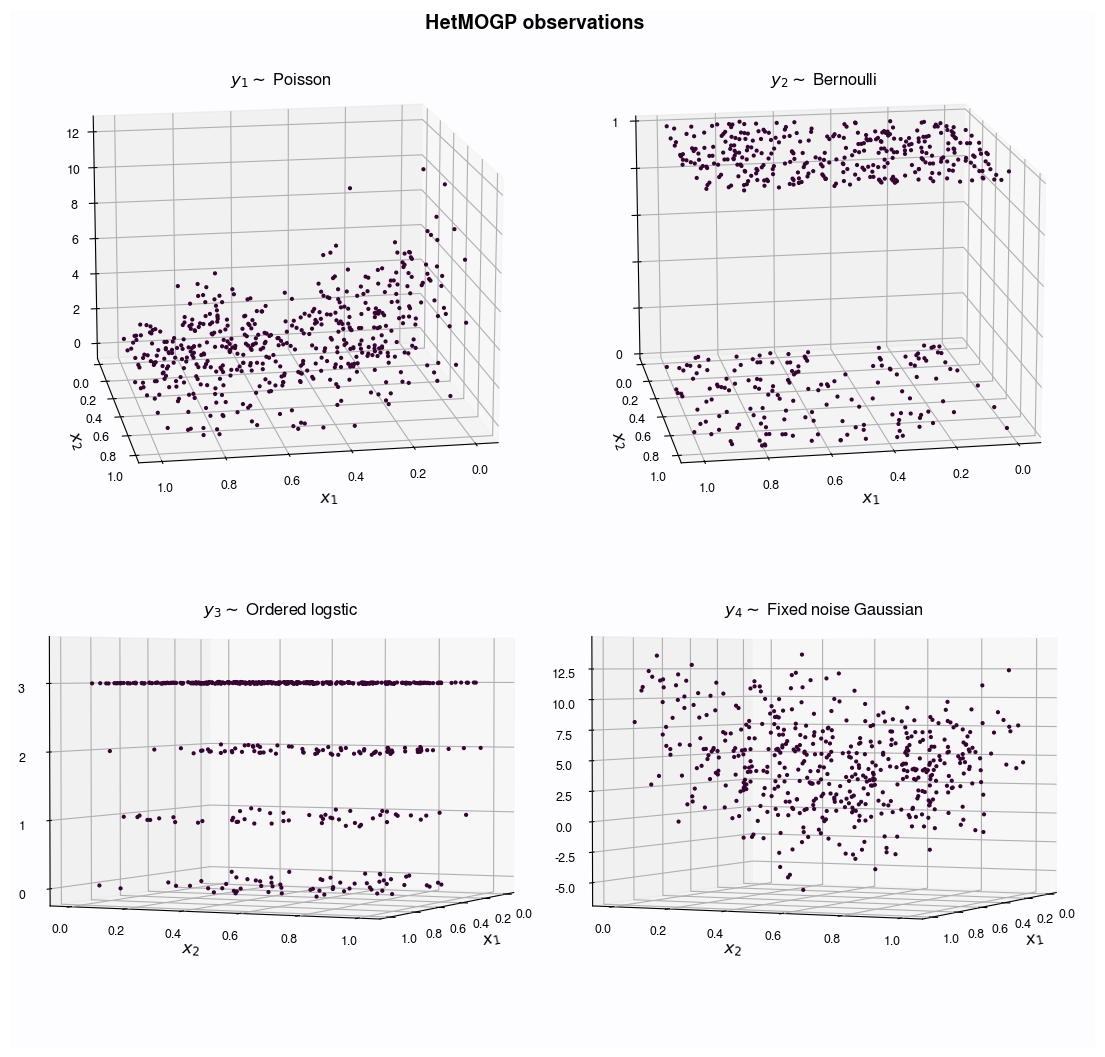

In [961]:
# Plot 4

fs_title = 12
alpha = 0

# Create figure
fig = plt.figure(figsize=(14,52))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_11.reshape((N, N)).numpy(), alpha=alpha)
ax1.scatter(x1, x2, y1, color='#360332', alpha=1, s=4)

ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 5)
ax1.set_xticklabels(ax1.get_xticks().round(1), fontsize=fs)
ax1.set_yticklabels(ax1.get_yticks().round(1), fontsize=fs)
ax1.set_zticklabels(np.int32(ax1.get_zticks()), fontsize=fs)
# ax1.annotate("$\exp(f(\mathbf{x}))$", (.023,.033), fontsize=10)
# ax1.view_init(-358, 25)
ax1.view_init(-345, 80)

ax1.set_title('$y_1 \sim$ Poisson', y=.92, fontsize=fs_title)

# fig.tight_layout()

# fig.savefig(os.path.join(save_image_path, "Poisson_likelihood.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')


# Plot 4

# params
torch.manual_seed(88)

# samples
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_21.reshape((N, N)).numpy(), alpha=alpha)
ax2.scatter(x1, x2, y2, color='#360332', alpha=1, s=4)

ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
# print(ax.get_zlim())
ax2.set_zlim(0, 1)

ax2.set_xticklabels(ax2.get_xticks().round(1), fontsize=fs)
ax2.set_yticklabels(ax2.get_yticks().round(1), fontsize=fs)
zticks = ax2.zaxis.get_major_ticks()
for ztick in zticks[1:-1]:
    ztick.label1.set_visible(False)
ax2.set_zticklabels(np.int32(ax2.get_zticks()), fontsize=fs)

# ax2.set_zticklabels([str(0.)] + [""]* len(ax2.get_zticks()) + [str(1.)], fontsize=fs)
# ax2.annotate("${logit}^{-1}(f(\mathbf{x}))$", (.057,.005), fontsize=10)
ax2.view_init(-345, 80)

ax2.set_title('$y_2 \sim$ Bernoulli', y=.92, fontsize=fs_title)
# ax2.set_zticklabels([0,1])



##


# Plot 4
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_31.reshape((N, N)).numpy(), alpha=alpha)
ax3.scatter(x1, x2, y3, color='#360332', alpha=1, s=4)

ax3.set_xlabel("$x_1$")
ax3.set_ylabel("$x_2$")
# print(ax.get_zlim())
# ax.set_zlim(0, 1)
ax3.set_zticks([0,1,2,3])
ax3.set_xticklabels(ax3.get_xticks().round(1), fontsize=fs)
ax3.set_yticklabels(ax3.get_yticks().round(1), fontsize=fs)
ax3.set_zticklabels(ax3.get_zticks().round(2), fontsize=fs)
# ax3.annotate("$f(\mathbf{x})$", (.062,.004), fontsize=10)
# ax3.view_init(-358, 50)
ax3.view_init(-358, 25)

ax3.set_title('$y_3 \sim$ Ordered logstic', y=.85, fontsize=fs_title)


###



# Plot 2


# Plot 2
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(x1_grid.numpy(), x2_grid.numpy(), surf_41.reshape((N, N)).numpy(), alpha=alpha)
ax4.scatter(x1, x2, y4, color='#360332', alpha=1, s=4) 

# for i in line_indices:
#     ax2.plot([x1[i], x1[i]], [x2[i], x2[i]], [samples2[i], z_surface[i]], color='red', lw=.55, ls="--")

ax4.set_xlabel("$x_1$")
ax4.set_ylabel("$x_2$")
# ax2.set_zlabel("f(x)", labelpad=-2.5)
# ax2.set_zlim(-.8, 1.6)
ax4.set_xticklabels(ax4.get_xticks().round(1), fontsize=fs)
ax4.set_yticklabels(ax4.get_yticks().round(1), fontsize=fs)
ax4.set_zticklabels(ax4.get_zticks().round(1), fontsize=fs)
# ax4.annotate("$f(\mathbf{x})$", (.068,-.001), fontsize=10)
# ax2.view_init(*view_init)
ax4.view_init(-358, 25)
# ax4.view_init(-358, 50)
# ax2.grid(False)
# ax2.set_xticks([0, 1])
# ax2.set_yticks([0, 1])
# ax2.set_zticks([])
ax4.set_title("$y_4 \sim$ Fixed noise Gaussian", y=.85, fontsize=fs_title)

fig.suptitle("HetMOGP observations", fontsize=fs_title+2, weight="bold", y=.594)

fig.tight_layout()

fig.subplots_adjust(wspace=-.0, hspace=-.859)

# fig.savefig(os.path.join(save_image_path, "hetmogp_observations.png"), dpi=dpi, pad_inches=0, bbox_inches='tight')

#### A-HetMOGP

##### Extend HetMOGP to A-HetMOGP. Plot comparison between HetMOGP and A-HetMOGP

In [962]:
Y = torch.tensor(y_data)
X = torch.tensor(np.vstack([x1, x2]).T)

train_idx, test_idx = torch.utils.data.random_split(X, [.8, .2], \
    generator=torch.Generator().manual_seed(80))
train_idx, test_idx = train_idx.indices, test_idx.indices

train_x = X[train_idx]
test_x = X[test_idx]
train_y = Y[train_idx,:]
test_y = Y[test_idx,:]

In [963]:
batch_shape=torch.Size([1])
input_dims = train_x.size(-1)
ard_num_dims = input_dims
num_inducing = train_x.size(0)
  
kernels_non_additive = [
    ProductKernel(
        RBFKernel(batch_shape=batch_shape, ard_num_dims=ard_num_dims),
        PeriodicKernel(batch_shape=batch_shape, ard_num_dims=ard_num_dims)
    ),
    RBFKernel(batch_shape=batch_shape, ard_num_dims=ard_num_dims),
]

active_dims_non_additive = [
    [0, 1], 
    [0, 1]
]

kernels_additive = [
    ProductKernel(
        RBFKernel(batch_shape=batch_shape),
        PeriodicKernel(batch_shape=batch_shape)
    ),
    ProductKernel(
        RBFKernel(batch_shape=batch_shape),
        PeriodicKernel(batch_shape=batch_shape)
    ),
    RBFKernel(batch_shape=batch_shape),
    RBFKernel(batch_shape=batch_shape),
]

active_dims_additive = [
    [0], 
    [1],
    [0], 
    [1],
]

likelihoods = ["Poisson", "Bernoulli", "OrderedLogistic", "HetNormal"]
model_additive = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels_additive,
                         active_dims=active_dims_additive, num_inducing=100, jitter_val = 1e-3,
                         n_classes=4)
model_non_additive = HetMOGP(train_x, num_lpf=5, likelihoods=likelihoods, kernels=kernels_non_additive,
                         active_dims=active_dims_non_additive, num_inducing=100, jitter_val = 1e-3,
                         n_classes=4)

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

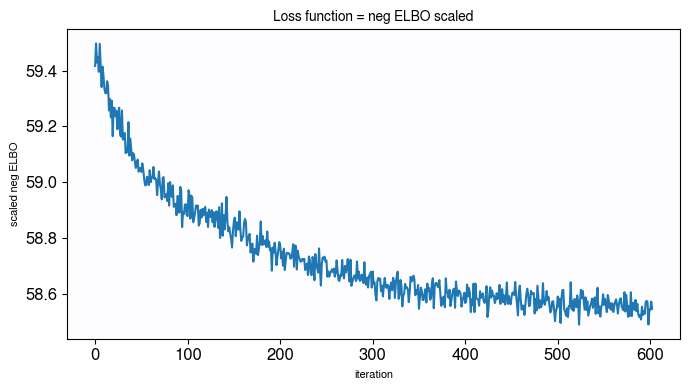

In [964]:
train_model(model_additive, sd_input=False, plot=True)

Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

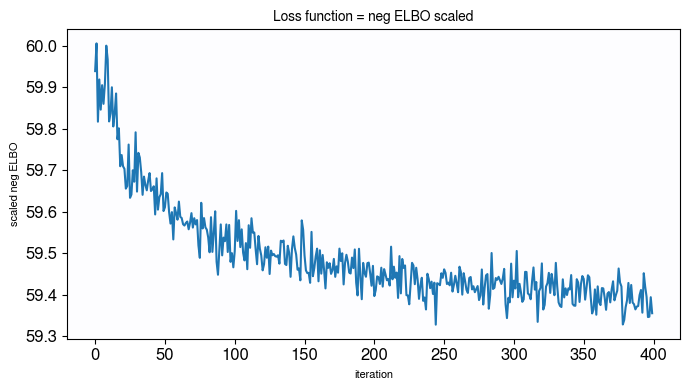

In [965]:
train_model(model_non_additive, sd_input=False, plot=True)

In [966]:
def get_predictions_hmogp_example(model, x, num_samples=100):
    predictive_dist = Predictive(model.model, guide=model.guide, num_samples=num_samples)
    predictions = predictive_dist(x, None)
    y0_pred = predictions["hmogp.y_0"][0].squeeze(0).cpu().numpy()
    y1_pred = predictions['hmogp.y_1'][0].squeeze(0).cpu().numpy()
    y2_pred = predictions['hmogp.y_2'][0].squeeze(0).cpu().numpy()
    y3_pred = predictions['hmogp.y_3'][0].squeeze(0).cpu().numpy()
    f_samples = predictions["hmogp.f(x)"].cpu()
    y_pred = np.vstack([y0_pred, y1_pred, y2_pred, y3_pred]).T
    
    return y_pred, f_samples

In [967]:
model_additive.eval()

with torch.no_grad():
    ilf_a = model_additive.variational_strategy.ind_latent_fn
    lmc_coefficients_a = model_additive.variational_strategy.lmc_coefficients.cpu().detach()
    ilf_lower_a, ilf_upper_a = ilf_a.confidence_region()
    ilf_mean_a = ilf_a.mean
    ilf_lower_a, ilf_upper_a, ilf_mean_a = ilf_lower_a.detach().cpu(), ilf_upper_a.detach().cpu(), ilf_mean_a.detach().cpu()
    
    
model_non_additive.eval()

with torch.no_grad():
    ilf_na = model_non_additive.variational_strategy.ind_latent_fn
    lmc_coefficients_na = model_non_additive.variational_strategy.lmc_coefficients.cpu().detach()
    ilf_lower_na, ilf_upper_na = ilf_na.confidence_region()
    ilf_mean_na = ilf_na.mean
    ilf_lower_na, ilf_upper_na, ilf_mean_na = ilf_lower_na.detach().cpu(), ilf_upper_na.detach().cpu(), ilf_mean_na.detach().cpu()

In [968]:
def compute_f_pd_p(
    x, 
    input_dim, 
    lpf_j, # j-th dimension of lpf, j \in {1,...,J}
    ilf, 
    lmc, 
    active_dims, 
    get_indices=True
):
    active_dims = np.array(active_dims)
    lpf_idx, _ = np.where(active_dims==[input_dim])
    indices = np.argsort(x[:,input_dim])
    f_pd = (ilf.T[:,lpf_idx] @ lmc[lpf_idx,:])[indices,lpf_j]
    if get_indices:
        return indices, f_pd
    else:
        return f_pd

In [1084]:
# visualize the result

def plot_additive_ilf(train_x, active_dims, ilf_mean, ilf_lower, ilf_upper, savefig=False, **kwargs):

    input_dims = train_x.size(-1)
    nrows = ilf_mean.shape[0] // input_dims
    ncols = input_dims
    width = 3.5 * ncols
    height = 1.7 * nrows
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True)

    color = "#6F499D"
    ymin = np.repeat(np.inf, nrows)
    ymax = np.repeat(-np.inf, nrows)
    lw = 1.1
    alpha = .25

    i = 0
    for ilf_idx, dim_ in enumerate(active_dims):
        
        j = dim_[0]
        indices = np.argsort(train_x[:,j])

        ax[i,j].plot(train_x[indices,j], ilf_mean[ilf_idx,indices], color=color, alpha=0.9, lw=lw, label="Mean")
        ax[i,j].fill_between(
            train_x[indices,j], ilf_lower[ilf_idx,indices],
            ilf_upper[ilf_idx,indices], alpha=alpha, color=color,
            label="CI region"
        )
        
        ax[i,j].set_xlim([0,1])
        ax[i,j].tick_params(axis='both', which='major', labelsize=9)  # Adjust the size of the ticks
        ax[i,j].set_ylabel(r'$u_{{{}}}^{{({})}}{{(x_{})}}$'.format(ilf_idx+1, j+1, j+1), weight="bold", fontsize=10)
        ax[nrows-1,j].set_xlabel(r'$x_{{{}}}$'.format(j+1), weight="bold", fontsize=10)
        
        ymin_, ymax_ = ax[i,j].get_ylim()
        if ymin_ < ymin[i]:
            ymin[i] = ymin_
        if ymax_ > ymax[i]:
            ymax[i] = ymax_
            
        if (i == 1) and (j == 1):  # Add the legend to the first subplot only
                ax[i,j].legend(fontsize=8)  # Adjust the size of the legend font

        if j+1 == input_dims:
            i += 1
            
    for i in range(nrows):
        for j in range(ncols):        
            ax[i,j].set_ylim([ymin[i], ymax[i]])        

    fig.suptitle("Additive ILF: $u_1^{(1)}, u_2^{(2)}, u_3^{(1)}, u_4^{(2)}$", y=.97, fontsize=10)
    fig.tight_layout()
    plt.show()
    
    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] == ".png") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

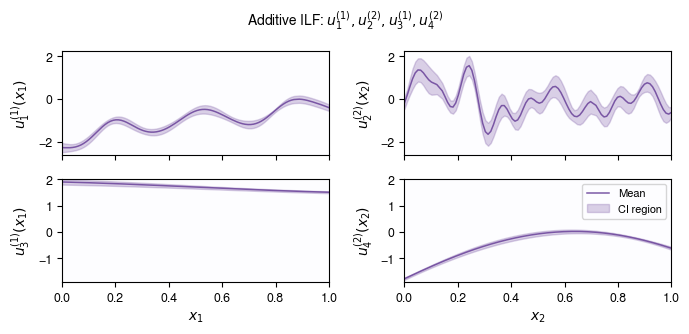

In [1085]:
plot_additive_ilf(train_x, active_dims_additive, ilf_mean_a, ilf_lower_a, ilf_upper_a, savefig=True, filename="ahmogp_ilf.png")

In [1066]:
# visualize the result

def plot_additive_ilf(train_x, active_dims, ilf_mean, ilf_lower, ilf_upper, savefig=False, **kwargs):

    n_ilf = ilf_mean.size(0)
    nrows = n_ilf
    ncols = np.array(active_dims).max()+1
    width = 3.5 * ncols
    height = 1.7 * nrows

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True)

    ymin = np.repeat(np.inf, nrows)
    ymax = np.repeat(-np.inf, nrows)
    color = "#6F499D"
    size = 3
    alpha = .9

    for i in range(n_ilf):
        dims = active_dims[i]
        for j in dims:
            
            indices = np.argsort(train_x[:,j])
            ax[i,j].scatter(train_x[indices,j], ilf_mean[i,indices], alpha=alpha, s=size, color=color, label="Mean")
            ax[i,j].fill_between(
                train_x[indices,j], ilf_lower[i,indices],
                ilf_upper[i,indices], alpha=0.3, color=color,
                step="mid",
                label="CI region"
            )
            
            ax[i,j].set_xlim([0,1])
            ax[i,j].tick_params(axis='both', which='major', labelsize=9)  # Adjust the size of the ticks
            ax[i,j].set_ylabel(r'$u_{{{}}}{{(x_{})}}$'.format(i+1, j+1), weight="bold", fontsize=10)
            ax[nrows-1,j].set_xlabel(r'$x_{{{}}}$'.format(j+1), weight="bold", fontsize=10)
            
            ymin_, ymax_ = ax[i,j].get_ylim()
            if ymin_ < ymin[i]:
                ymin[i] = ymin_
            if ymax_ > ymax[i]:
                ymax[i] = ymax_
                
            if (i == 1) and (j == 1):  # Add the legend to the first subplot only
                ax[i,j].legend(fontsize=8)  # Adjust the size of the legend font
            
    for i in range(nrows):
        for j in range(ncols):        
            ax[i,j].set_ylim([ymin[i], ymax[i]])        

    fig.suptitle("Non-additive ILF: $u_1, u_2$", y=.97, fontsize=10)
    fig.tight_layout()
    plt.show()

    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] == ".png") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

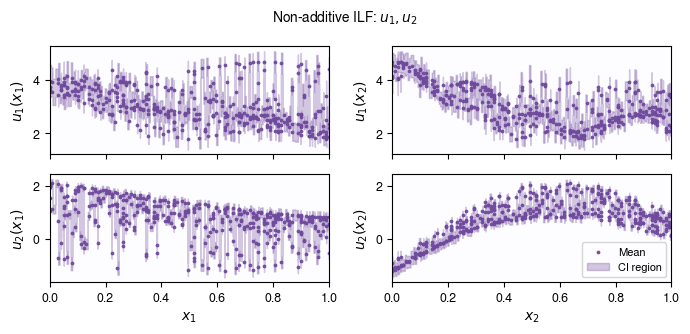

In [1070]:
plot_additive_ilf(train_x, active_dims_non_additive, ilf_mean_na, ilf_lower_na, ilf_upper_na, savefig=True, filename="hmogp_ilf.png")

In [975]:
y_pred_a, f_samples_a = get_predictions_hmogp_example(model_additive, test_x)
y_pred_na, f_samples_na = get_predictions_hmogp_example(model_non_additive, test_x)

In [976]:
def get_num_lpf(likelihood, **kwargs):
    n_categories = None
    n_compositions = None
    if likelihood == "Categorical":
        n_categories = kwargs["n_categories"]
    if likelihood == "HetDirichlet":
        n_compositions = kwargs["n_compositions"]
    
    likelihood_lpf_dict = {
        "HetNormal": 2,
        "Poisson": 1,
        "Bernoulli": 1,
        "Categorical": n_categories,
        "OrderedLogistic": 1,
        "HetDirichlet": n_compositions,
    }
    return likelihood_lpf_dict[likelihood]

def get_observation_dim(likelihood, **kwargs):
    n_categories = 0
    n_compositions = 0
    if "n_categories" in kwargs.keys():
        n_categories = kwargs["n_categories"]
    if "n_compositions" in kwargs.keys():
        n_compositions = kwargs["n_compositions"]
    
    likelihood_lpf_dict = {
        "HetNormal": 2,
        "Poisson": 1,
        "Bernoulli": 1,
        "Categorical": n_categories,
        "OrderedLogistic": 1,
        "HetDirichlet": n_compositions,
    }
    return likelihood_lpf_dict[likelihood]

def transform_ulpf(
    likelihood, 
    j, # the j-th lpf of lpf_d
    ulpf,
    **kwargs
):

    response_fn_dict = {
        "HetNormal": {"0": ulpf, "1": torch.exp(ulpf)},
        "Poisson": {"0": ulpf},
        "Bernoulli": {"0": torch.sigmoid(ulpf)},
        # "Categorical": torch.softmax(ulpf),
        "OrderedLogistic": {"0": ulpf},
        # "HetDirichlet": n_compositions,
    }
    return response_fn_dict[likelihood][str(j)]

In [1062]:
from matplotlib.gridspec import GridSpec
def plot_ahetmogp(
    train_x, 
    test_x, 
    test_y,
    y_pred,
    likelihood, 
    lpf_d, 
    ilf_mean,
    ilf_lower,
    ilf_upper,
    lmc_coefficients,
    active_dims,
    additive=True,
    title=None,
    y_pred_from_true_lpf=None,
    plot_obs=False,
    plot_scatter_2d=False,
    savefig=False,
    **kwargs,
):

    lpf_Jd = get_num_lpf(likelihood, **kwargs)
    
    # setup categorical plots
    has_categorical = likelihood in ["Bernoulli", "Categorical", "OrderedLogistic"]
    has_categorical_plot = has_categorical*plot_obs
    nobrows = plot_obs + has_categorical_plot
    categorical_row = lpf_Jd*has_categorical_plot
    n_categories = int((test_y[:,lpf_d].max()+1)*(has_categorical_plot))
    
    nrows = lpf_Jd + nobrows
    ncols = train_x.size(-1)
    width = 3.5 * ncols
    height = .8 + 1.1*nrows + .85*(has_categorical_plot) + .05*n_categories
    # fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True)
    fig = plt.figure(figsize=(width, height))
    gs = GridSpec(nrows, ncols, figure=fig)
    ymin = np.repeat(np.inf, nrows)
    ymax = np.repeat(-np.inf, nrows)
    lw = 1.1

    # color_test = "#360332"
    # color_ahmogp = "#880E4F"
    # color_ind = "#2081BB"
    color = "#6F499D"
    color_test = "#EE6C00"
    color_ahmogp = "#6F499D"

    axs = []

    for i in range(nrows):     
        for j in range(ncols):  
            if (i <= (lpf_Jd-1)) or (plot_obs == False):
                ax = fig.add_subplot(gs[i,j])    
                d_j = lpf_d + i                
                # lpf have to use train_x, but ppc on observations can be based on test_x
                indices, ulpf_mean = compute_f_pd_p(train_x, j, d_j, ilf_mean, lmc_coefficients, active_dims)
                _, ulpf_lower = compute_f_pd_p(train_x, j, d_j, ilf_lower, lmc_coefficients, active_dims)
                _, ulpf_upper = compute_f_pd_p(train_x, j, d_j, ilf_upper, lmc_coefficients, active_dims)
                
                lpf_mean = transform_ulpf(likelihood, i, ulpf_mean)
                lpf_lower = transform_ulpf(likelihood, i, ulpf_lower)
                lpf_upper = transform_ulpf(likelihood, i, ulpf_upper)
                
                if additive:
                    ax.plot(train_x[indices,j], lpf_mean, color=color, alpha=0.9, lw=lw, label="Mean")
                else:
                    ax.scatter(train_x[indices,j], lpf_mean, color=color, alpha=0.9, s=3, label="Mean")
                ax.fill_between(
                    train_x[indices,j], lpf_lower,
                    lpf_upper, alpha=.25, color=color,
                    label="CI region"
                )
                if additive:
                    ylabel = r'$\tilde{{f}}_{{{},{}}}^{{~({})}}$'.format(d_j+1, i+1, j+1)
                else:
                    ylabel = r'$\tilde{{f}}_{{{},{}}}$'.format(d_j+1, i+1)
                ax.set_ylabel(ylabel, weight="bold", fontsize=10)
                axs.append(ax)
            elif plot_obs:
                if has_categorical:
                    plot_cm = False
                    plot_two_cm = y_pred_from_true_lpf is not None
                    if (j <= 1) and (i == categorical_row) and (not plot_scatter_2d):
                        y_ = y_pred[:,lpf_d]
                        subtitle = "Confusion matrix: predicted density \n from estimated LPF"
                        if (plot_two_cm) and (j == 0):
                            k = 0
                            y_ = y_pred_from_true_lpf
                            subtitle = "Confusion matrix: predicted density \n from true LPF"
                            plot_cm = True  
                        elif (plot_two_cm) and (j == 1):
                            plot_cm = True  
                        elif (not plot_two_cm) and (j == 0):
                            plot_cm = True
                        if plot_cm: 
                            ax_cat = fig.add_subplot(gs[categorical_row:,j])  
                            cm = confusion_matrix(test_y[:,lpf_d], y_)
                            ax_cat.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
                            for ii in range(cm.shape[0]):
                                for jj in range(cm.shape[1]):
                                    ax_cat.text(x=jj, y=ii,s=cm[ii, jj], va='center', ha='center', size=10)
                            ax_cat.tick_params(axis='both', which='major', labelsize=9) 
                            ax_cat.set_ylabel("True", fontsize=10)
                            ax_cat.set_xlabel("Predicted", fontsize=10)
                            ax_cat.set_title(subtitle, fontsize=10)
                            ax_cat.xaxis.set_ticks_position('bottom')
                    elif (plot_scatter_2d) and (i == categorical_row) and (j <= 1):
                        if j == 0:
                            y_ = test_y
                            marker = "o"
                            s = 5
                            subtitle = "Test data"
                        elif j == 1:
                            y_ = torch.tensor(y_pred)
                            s = 7
                            marker = "x"
                            subtitle = "Predicted data"
                        ax_cat = fig.add_subplot(gs[categorical_row:,j])  
                        idx_labels = []
                        for k in range(n_categories):
                            idx = (y_[:,lpf_d]==k).nonzero().flatten()
                            idx_labels.append(idx)
                        # colors = ['#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
                        for k, idx in enumerate(idx_labels):                            
                            ax_cat.scatter(test_x[idx,0], test_x[idx,1], s=s, alpha=1, label=r'$y_{{{}}}={{{}}}$'.format(lpf_d+1, k), marker=marker)

                        if j == 0:
                            ax_cat.legend(fontsize=8)
                        ax_cat.set_title(subtitle, fontsize=10)
                        ax_cat.set_xlabel(r'$x_1$', weight="bold", fontsize=10)
                        ax_cat.set_ylabel(r'$x_2$', weight="bold", fontsize=10)
                        ax_cat.tick_params(axis='both', which='major', labelsize=9)  
                else:
                    ax = fig.add_subplot(gs[i,j])
                    alpha_test = .6
                    alpha_pred = .9
                    ax.scatter(test_x[:,j], test_y[:,lpf_d], alpha = alpha_test, label='Test data', s=5, color=color_test)
                    ax.scatter(test_x[:,j], y_pred[:,lpf_d], alpha = alpha_pred, label='Predictions', s=7, color=color_ahmogp, marker="x")
                    ax.set_ylabel(f'$y_{lpf_d+1}$', fontsize=10)  # Add the y label using LaTeX
                    if j==0:  # Add the legend to the first subplot only
                        ax.legend(fontsize=8)  # Adjust the size of the legend font
                    axs.append(ax)
            ax.set_xlim([0,1])
            ax.tick_params(axis='both', which='major', labelsize=9)  # Adjust the size of the ticks
            # set x_label on the last relevant row
            if i == max(categorical_row-1, (not has_categorical_plot)*(nrows-1)):            
                ax.set_xlabel(r'$x_{{{}}}$'.format(j+1), weight="bold", fontsize=10)
            
            ymin_, ymax_ = ax.get_ylim()
            if ymin_ < ymin[i]:
                ymin[i] = ymin_
            if ymax_ > ymax[i]:
                ymax[i] = ymax_
    
    for i_, ax in enumerate(axs):
        i = i_ // ncols
        ax.set_ylim([ymin[i], ymax[i]])
        if i < (nrows-1):
            ax.set_xticklabels([])
            
    if title is None:
        if additive:
            title = r"Additive LPF: $\tilde{{\mathbf{{f}}}}_{{{}}}$".format(lpf_d+1)
        else:
            title = r"Non-additive LPF: $\tilde{{\mathbf{{f}}}}_{{{}}}$".format(lpf_d+1)
        add_title = ""
        if plot_obs:
            add_title = r" and ppc from $y_{} \sim ${}$(\tilde{{\mathbf{{f}}}}_{{{}}})$".format(lpf_d+1, likelihood, lpf_d+1)
        title += add_title
    fig.suptitle(title, fontsize=10)
    fig.tight_layout()
    plt.show()

    if savefig:
        filename = kwargs["filename"]
        assert (filename is not None) and (filename[-4:] == ".png") 
        fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [994]:
# y2
y2_pred_from_true_lpf = dist_y2.sample_n(1).squeeze(0).numpy()
y2_pred_from_true_lpf = y2_pred_from_true_lpf[test_idx]

# y3
y3_pred_from_true_lpf = dist_y3.sample_n(1).squeeze(0).numpy()
y3_pred_from_true_lpf = y3_pred_from_true_lpf[test_idx]

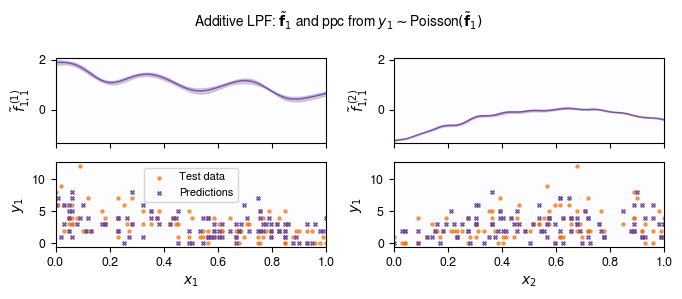

In [1071]:
plot_ahetmogp(train_x, test_x, test_y, y_pred_a, "Poisson", 0, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dims_additive, plot_obs=True, savefig=True, filename="ahmogp_poisson.png")

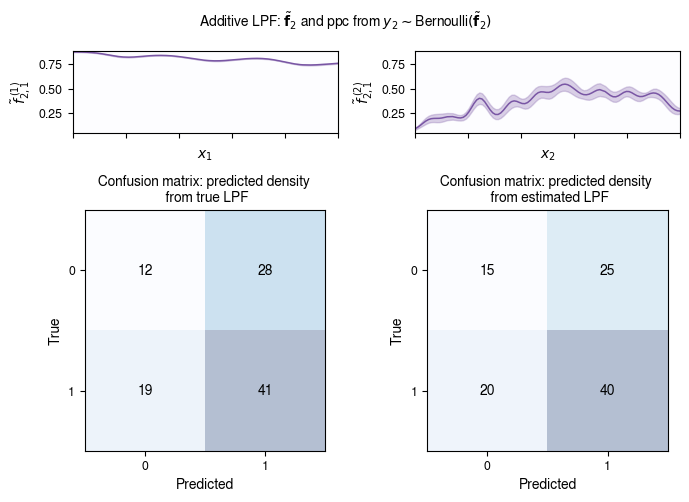

In [1072]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, y_pred_a, "Bernoulli", 1, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dims_additive, title=None, plot_obs=True, y_pred_from_true_lpf=y2_pred_from_true_lpf, savefig=True, filename="ahmogp_bernoulli.png")

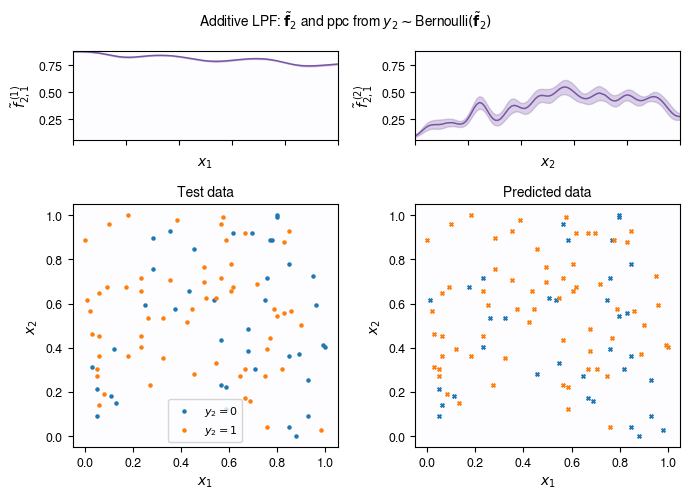

In [1073]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, y_pred_a, "Bernoulli", 1, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dims_additive, title=None, plot_obs=True, plot_scatter_2d=True, y_pred_from_true_lpf=y2_pred_from_true_lpf, savefig=True, filename="ahmogp_bernoulli1.png")

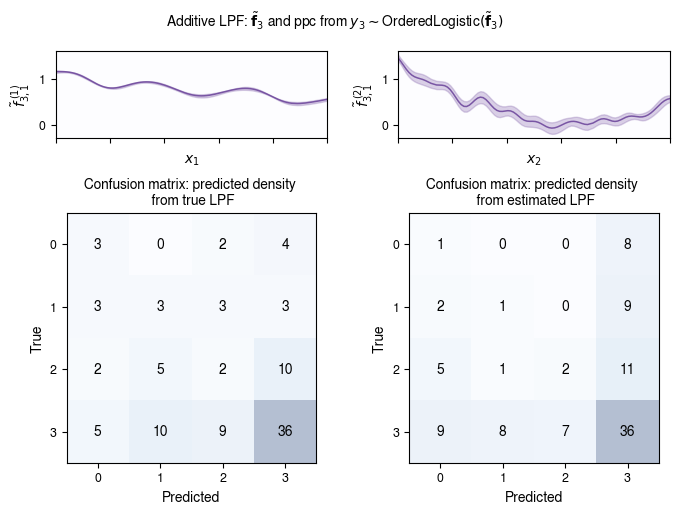

In [1074]:
plot_ahetmogp(train_x, test_x, test_y, y_pred_a, "OrderedLogistic", 2, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dims_additive, plot_obs=True, plot_scatter_2d=False, y_pred_from_true_lpf=y3_pred_from_true_lpf, savefig=True, filename="ahmogp_orderedlogistic.png")

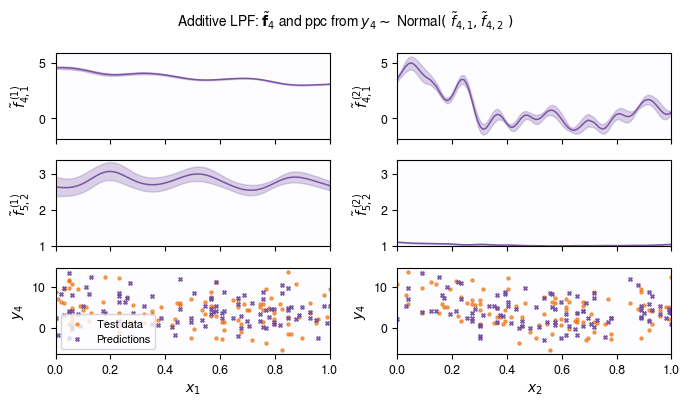

In [1075]:
title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, y_pred_a, "HetNormal", 3, ilf_mean_a, ilf_lower_a, ilf_upper_a, lmc_coefficients_a, active_dims_additive, title=title, plot_obs=True, savefig=True, filename="ahmogp_gaussian.png")

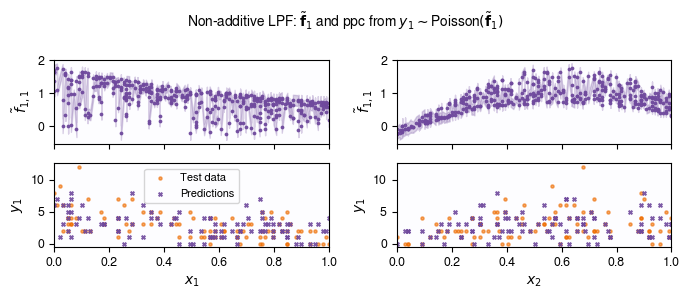

In [1076]:
plot_ahetmogp(train_x, test_x, test_y, y_pred_a, "Poisson", 0, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dims_non_additive, plot_obs=True, additive=False, savefig=True, filename="hmogp_poisson.png")

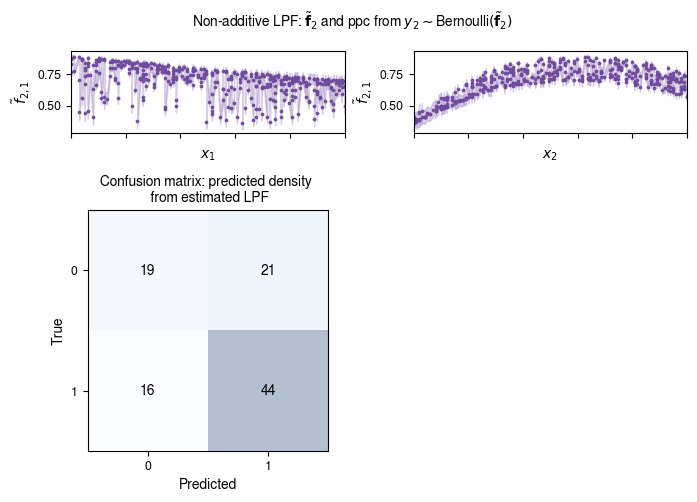

In [1077]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, y_pred_na, "Bernoulli", 1, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dims_non_additive, title=None, plot_obs=True, additive=False, savefig=True, filename="hmogp_bernoulli.png")

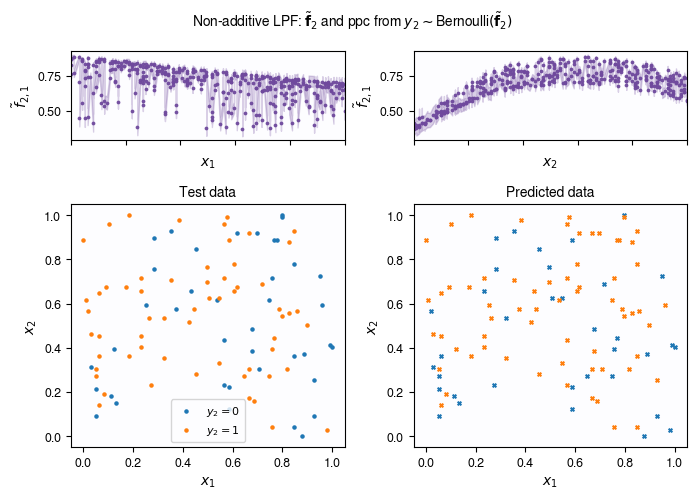

In [1078]:
# title = r"Additive LPF: $\tilde{\mathbf{f}}_{4}$ and ppc from $y_4 \sim$ Normal$(~\tilde{f}_{4,1}, \tilde{f}_{4,2}~)$"
plot_ahetmogp(train_x, test_x, test_y, y_pred_na, "Bernoulli", 1, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dims_non_additive, title=None, plot_scatter_2d=True, plot_obs=True, additive=False, savefig=True, filename="hmogp_bernoulli1.png")

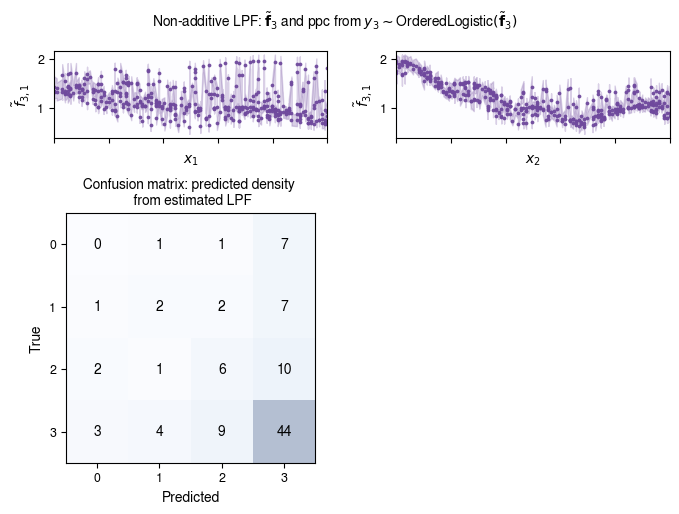

In [1079]:
plot_ahetmogp(train_x, test_x, test_y, y_pred_na, "OrderedLogistic", 2, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dims_non_additive, title=None, plot_obs=True, additive=False, savefig=True, filename="hmogp_orderedlogistic.png")

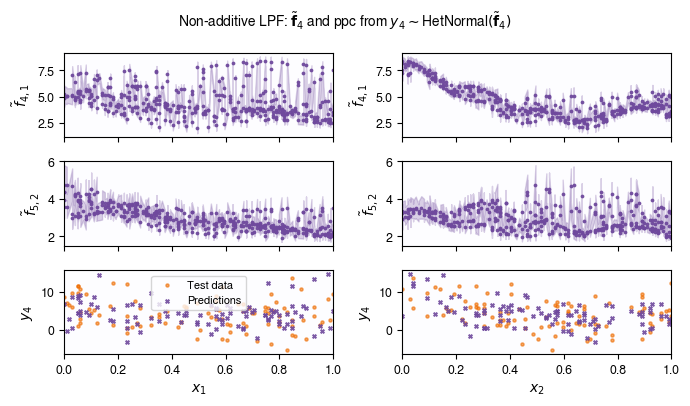

In [1080]:
plot_ahetmogp(train_x, test_x, test_y, y_pred_na, "HetNormal", 3, ilf_mean_na, ilf_lower_na, ilf_upper_na, lmc_coefficients_na, active_dims_non_additive, title=None, plot_obs=True, additive=False, savefig=True, filename="hmogp_gaussian.png")